In [1]:
### import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
# Lire le fichier en sautant la première ligne
df = pd.read_excel("/content/drive/MyDrive/GastricCancerData.xlsx", skiprows=1)
# Afficher les premières lignes du dataframe
df.head()

,AGE,SEXE,Cardiopathie,Ulceregastrique,Douleurepigastrique,Ulcero-bourgeonnant,Constipation,Denitrution,Tabac,Mucineux,Tubuleux,Infiltrant,Stenosant,Metastases,Adenopathie,Traitement,Tempsdesuivi (Mois),Deces
0,65,F,NON,NON,OUI,NON,OUI,OUI,OUI,OUI,NON,OUI,OUI,OUI,OUI,Chirurgie_Exclusive,1,OUI
1,34,F,NON,NON,OUI,NON,OUI,NON,OUI,OUI,OUI,OUI,OUI,OUI,OUI,Chirurgie_Chimiotherapie,1,OUI
2,55,H,NON,NON,OUI,NON,OUI,NON,OUI,OUI,NON,OUI,NON,OUI,OUI,Chirurgie_Exclusive,1,OUI
3,60,F,OUI,OUI,OUI,NON,OUI,NON,OUI,OUI,OUI,OUI,NON,OUI,NON,Chirurgie_Exclusive,2,NON
4,65,H,OUI,NON,OUI,NON,OUI,NON,OUI,NON,NON,OUI,OUI,NON,OUI,Chirurgie_Chimiotherapie,2,OUI


In [2]:
df = pd.read_excel("D:/UADB/MEMOIRE/Data/GastricCancerData.xlsx")

In [3]:
#affichage des dimensions
df.shape

(337, 18)

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Identifier les colonnes catégoriques
CatCols = df.select_dtypes(include=['object']).columns
# Encodage des variables catégoriques
#Label Encoding
label_encoder = LabelEncoder()
for col in CatCols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

df.head()

,AGE,SEXE,Cardiopathie,Ulceregastrique,Douleurepigastrique,Ulcero-bourgeonnant,Constipation,Denitrution,Tabac,Mucineux,Tubuleux,Infiltrant,Stenosant,Metastases,Adenopathie,Traitement,Tempsdesuivi (Mois),Deces
0,65,0,0,0,1,0,1,1,1,1,0,1,1,1,1,1,1,1
1,34,0,0,0,1,0,1,0,1,1,1,1,1,1,1,0,1,1
2,55,1,0,0,1,0,1,0,1,1,0,1,0,1,1,1,1,1
3,60,0,1,1,1,0,1,0,1,1,1,1,0,1,0,1,2,0
4,65,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,2,1


# **Approche non parametrique de Kaplan - Meier**

In [5]:
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import (logrank_test, pairwise_logrank_test,multivariate_logrank_test,survival_difference_at_fixed_point_in_time_test)

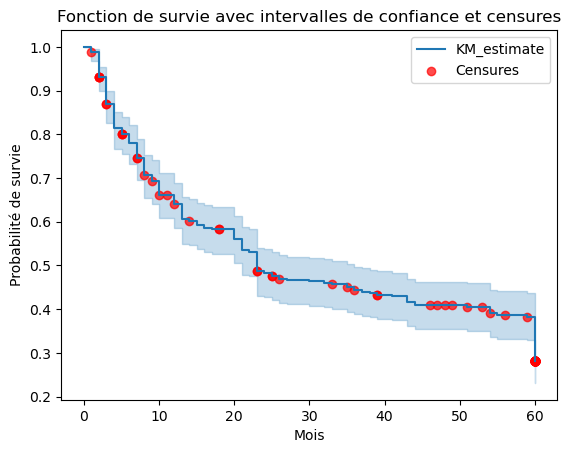

In [6]:
# Initialisation du Kaplan-Meier
kmf = KaplanMeierFitter()

# Ajustement du modèle avec les données
kmf.fit(df['Tempsdesuivi (Mois)'], event_observed=df['Deces'])

# Tracer la fonction de survie avec les intervalles de confiance
ax = kmf.plot_survival_function(ci_show=True)  # Affiche les intervalles de confiance

# Ajouter les points de censure
censored_times = df.loc[df['Deces'] == 0, 'Tempsdesuivi (Mois)']
survival_probabilities = [float(kmf.survival_function_at_times(time).iloc[0]) for time in censored_times]

plt.scatter(censored_times,
            survival_probabilities,
            color='red',
            label='Censures',
            alpha=0.7)

# Ajout des titres et légendes
plt.title('Fonction de survie avec intervalles de confiance et censures')
plt.xlabel('Mois')
plt.ylabel('Probabilité de survie')
plt.legend()
plt.show()

### **Probabilites de survie & de deces**

In [7]:
def probabilites_survie_deces(df, time_col, event_col):
    # Instancier l'estimateur Kaplan-Meier
    kmf = KaplanMeierFitter()

    # Ajuster le modèle à vos données
    kmf.fit(durations=df[time_col], event_observed=df[event_col])

    # Extraire les probabilités de survie
    survival_probabilities = kmf.survival_function_
    survival_probabilities.columns = ["Probabilité de survie"]

    # Calculer les probabilités de décès (1 - survie)
    survival_probabilities["Probabilité de décès"] = 1 - survival_probabilities["Probabilité de survie"]

    # Ajouter les temps (index)
    survival_probabilities.reset_index(inplace=True)
    survival_probabilities.rename(columns={"timeline": "Temps t"}, inplace=True)

    return survival_probabilities

# Exemple d'utilisation
# Charger vos données dans un DataFrame df
time_col = "Tempsdesuivi (Mois)"
event_col = "Deces"

# Appeler la fonction
resultat = probabilites_survie_deces(df, time_col, event_col)

# Afficher le tableau des probabilités
resultat

,Temps t,Probabilité de survie,Probabilité de décès
0,0.0,1.000000,0.000000
1,1.0,0.988131,0.011869
2,2.0,0.931581,0.068419
3,3.0,0.868270,0.131730
4,4.0,0.813623,0.186377
5,5.0,0.801480,0.198520
6,6.0,0.779984,0.220016
7,7.0,0.746205,0.253795
8,8.0,0.705953,0.294047
9,9.0,0.693514,0.306486


### **Taux de mortalites selon le sexe au file du temps**

In [8]:
def taux_mortalite_par_sexe(df, time_col, event_col, sexe_col):

    kmf = KaplanMeierFitter()
    resultats = {}

    # Diviser les données par sexe
    for sexe, group in df.groupby(sexe_col):
        # Ajuster le Kaplan-Meier pour chaque sexe
        kmf.fit(durations=group[time_col], event_observed=group[event_col], label=sexe)

        # Extraire les probabilités de décès cumulées
        surv_func = kmf.survival_function_.copy()
        surv_func["Probabilité de décès"] = 1 - surv_func.iloc[:, 0]  # 1 - Probabilité de survie
        surv_func.rename(columns={kmf._label: "Probabilité de survie"}, inplace=True)

        # Sauvegarder les résultats dans un dictionnaire
        surv_func.reset_index(inplace=True)
        surv_func.rename(columns={"timeline": "Temps t"}, inplace=True)
        resultats[sexe] = surv_func[["Temps t", "Probabilité de survie", "Probabilité de décès"]]

    return resultats

# Exemple d'utilisation
# Supposons un DataFrame `df` avec les colonnes "Tempsdesuivi (Mois)", "Deces" et "SEXE"
time_col = "Tempsdesuivi (Mois)"
event_col = "Deces"
sexe_col = "SEXE"  # Par exemple, 0 = Femme, 1 = Homme

# Appeler la fonction
taux_par_sexe = taux_mortalite_par_sexe(df, time_col, event_col, sexe_col)

# Afficher les résultats pour chaque groupe
for sexe, tableau in taux_par_sexe.items():
    print(f"\nTaux de mortalité pour le sexe : {sexe}")
    print(tableau)



Taux de mortalité pour le sexe : 0
    Temps t  Probabilité de survie  Probabilité de décès
0       0.0               1.000000              0.000000
1       1.0               0.980769              0.019231
2       2.0               0.942308              0.057692
3       3.0               0.896817              0.103183
4       4.0               0.811718              0.188282
5       5.0               0.798625              0.201375
6       6.0               0.785315              0.214685
7       7.0               0.745384              0.254616
8       8.0               0.705452              0.294548
9       9.0               0.692015              0.307985
10     10.0               0.651308              0.348692
11     12.0               0.617386              0.382614
12     13.0               0.583087              0.416913
13     14.0               0.583087              0.416913
14     16.0               0.576145              0.423855
15     18.0               0.576145              0.42

## **Tracer des courbes de Kaplan-Meier pour chaque groupe de la variable**

#### **Menu Déroulant**

In [10]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from IPython.display import display

# Initialisation des variables
time_col = "Tempsdesuivi (Mois)"
event_col = "Deces"
vars = [
    'Cardiopathie', 'Ulceregastrique', 'Douleurepigastrique',
    'Ulcero-bourgeonnant', 'Constipation', 'Denitrution', 'Tabac',
    'Mucineux', 'Tubuleux', 'Infiltrant', 'Stenosant', 'Metastases',
    'Adenopathie', 'Traitement', "SEXE"
]

# Définir des labels descriptifs pour les groupes
labels = {
    'Traitement': {0: "Chirurgie_Chimiothérapie", 1: "Chirurgie_Exclusive"},
    'SEXE': {0: "Femme", 1: "Homme"},
}

# Appliquer des labels génériques "Non" / "Oui" pour les autres variables
for var in vars:
    if var not in labels:
        labels[var] = {0: "Non", 1: "Oui"}

# Fonction de création du graphique Kaplan-Meier
def plot_kaplan_meier(variable):
    """
    Trace le graphique Kaplan-Meier pour une variable donnée et effectue le test de log-rank.
    """
    # Initialisation de la figure
    fig, ax = plt.subplots(figsize=(10, 8))

    # Instanciation du KaplanMeierFitter
    kmf = KaplanMeierFitter()

    # Tracer les courbes Kaplan-Meier pour chaque groupe de la variable
    for group in df[variable].unique():
        mask = (df[variable] == group)
        label = labels.get(variable, {}).get(group, str(group))  # Utiliser des labels ou des valeurs par défaut
        kmf.fit(df.loc[mask, time_col], event_observed=df.loc[mask, event_col], label=label)
        kmf.plot(ax=ax)

    # Test de log-rank entre les groupes
    groups = df[variable].unique()
    if len(groups) == 2:  # Test seulement si deux groupes existent
        group_0 = df.loc[df[variable] == groups[0]]
        group_1 = df.loc[df[variable] == groups[1]]
        results = logrank_test(
            group_0[time_col],
            group_1[time_col],
            event_observed_A=group_0[event_col],
            event_observed_B=group_1[event_col]
        )
        p_value = results.p_value
        ax.set_title(f"{variable}\nLog-rank p = {p_value:.4f}", fontsize=12)
    else:
        ax.set_title(f"{variable} (Pas de test log-rank, plus de 2 groupes)", fontsize=12)

    # Configurations supplémentaires
    ax.set_xlabel("Temps (mois)", fontsize=10)
    ax.set_ylabel("Probabilité de survie", fontsize=10)
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# Menu déroulant pour sélectionner la variable à analyser
dropdown = widgets.Dropdown(
    options=vars,
    value='Traitement',  # Valeur par défaut
    description='Variable:',
    disabled=False
)

# Afficher le menu et le graphique interactif
widgets.interactive(plot_kaplan_meier, variable=dropdown)


interactive(children=(Dropdown(description='Variable:', index=13, options=('Cardiopathie', 'Ulceregastrique', …

### **Variables significatives**

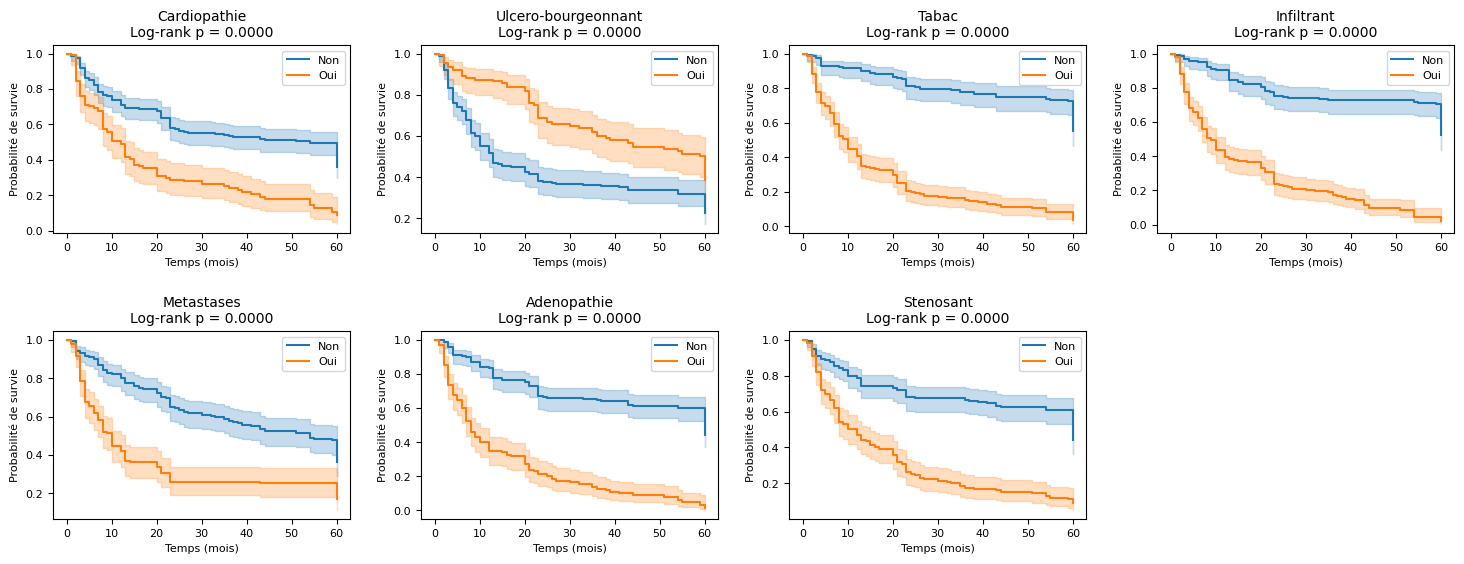

In [11]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Initialisation des variables
time_col = "Tempsdesuivi (Mois)"  # Nom de la colonne temps
event_col = "Deces"  # Nom de la colonne événement
vars = [
    'Cardiopathie',
    'Ulcero-bourgeonnant', 'Tabac',
     'Infiltrant', 'Metastases',
    'Adenopathie','Stenosant'
]

# Définir des labels descriptifs pour les groupes
labels = {
    'Traitement': {0: "Chirurgie_Chimiothérapie", 1: "Chirurgie_Exclusive"},
    'SEXE': {0: "Femme", 1: "Homme"},
    **{var: {0: "Non", 1: "Oui"} for var in vars if var not in ['Traitement', 'SEXE']}
}

# Déterminer la disposition de la grille pour les sous-graphiques
n_vars = len(vars)
n_cols = 4  # Augmenter le nombre de colonnes pour une disposition compacte
n_rows = (n_vars + n_cols - 1) // n_cols  # Calcul du nombre de lignes

# Création d'une figure compacte avec une grille
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()  # Convertir les axes en une liste pour un accès facile

for idx, var in enumerate(vars):
    ax = axes[idx]

    # Instanciation du KaplanMeierFitter
    kmf = KaplanMeierFitter()

    # Tracer les courbes de Kaplan-Meier pour chaque groupe de la variable
    for group in [0, 1]:
        mask = (df[var] == group)
        label = labels[var][group]  # Utiliser les labels descriptifs
        kmf.fit(df.loc[mask, time_col], event_observed=df.loc[mask, event_col], label=label)
        kmf.plot(ax=ax)

    # Test de log-rank entre les groupes 0 et 1
    results = logrank_test(
        df.loc[df[var] == 0, time_col],
        df.loc[df[var] == 1, time_col],
        event_observed_A=df.loc[df[var] == 0, event_col],
        event_observed_B=df.loc[df[var] == 1, event_col]
    )
    p_value = results.p_value

    # Ajouter le titre et le résultat du test de log-rank
    ax.set_title(f"{var}\nLog-rank p = {p_value:.4f}", fontsize=10)
    ax.set_xlabel("Temps (mois)", fontsize=8)
    ax.set_ylabel("Probabilité de survie", fontsize=8)
    ax.legend(fontsize=8)
    ax.tick_params(axis="both", labelsize=8)

# Supprimer les axes inutilisés si le nombre de variables n'est pas un multiple du nombre de colonnes
for idx in range(len(vars), len(axes)):
    fig.delaxes(axes[idx])

# Ajuster les espacements pour une disposition compacte
plt.tight_layout(pad=2.0)
plt.show()

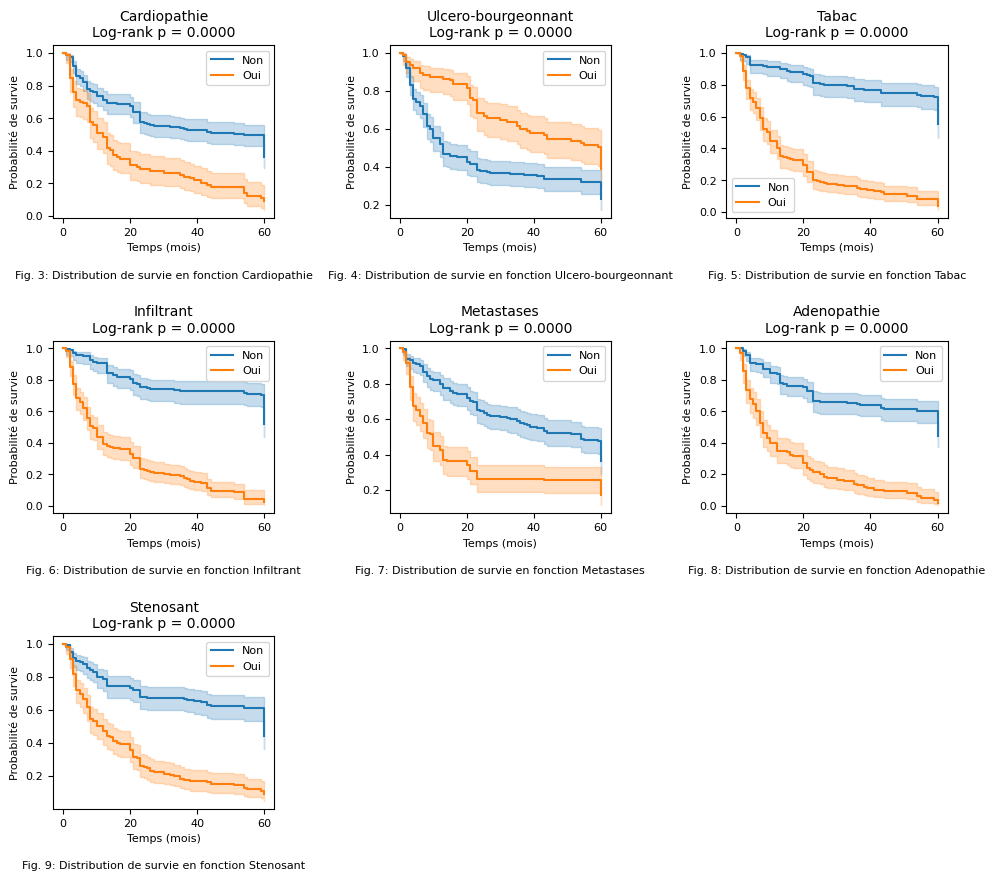

In [12]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Initialisation des variables
time_col = "Tempsdesuivi (Mois)"  # Nom de la colonne temps
event_col = "Deces"  # Nom de la colonne événement
vars = [
    'Cardiopathie',
    'Ulcero-bourgeonnant', 'Tabac',
    'Infiltrant', 'Metastases',
    'Adenopathie', 'Stenosant'
]

# Définir des labels descriptifs pour les groupes
labels = {
    'Traitement': {0: "Chirurgie_Chimiothérapie", 1: "Chirurgie_Exclusive"},
    'SEXE': {0: "Femme", 1: "Homme"},
    **{var: {0: "Non", 1: "Oui"} for var in vars if var not in ['Traitement', 'SEXE']}
}

# Déterminer la disposition de la grille pour les sous-graphiques
n_vars = len(vars)
n_cols = 3  # Augmenter le nombre de colonnes pour une disposition compacte
n_rows = (n_vars + n_cols - 1) // n_cols  # Calcul du nombre de lignes

# Création d'une figure compacte avec une grille
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axes = axes.flatten()  # Convertir les axes en une liste pour un accès facile

for idx, var in enumerate(vars):
    ax = axes[idx]

    # Instanciation du KaplanMeierFitter
    kmf = KaplanMeierFitter()

    # Tracer les courbes de Kaplan-Meier pour chaque groupe de la variable
    for group in [0, 1]:
        mask = (df[var] == group)
        label = labels[var][group]  # Utiliser les labels descriptifs
        kmf.fit(df.loc[mask, time_col], event_observed=df.loc[mask, event_col], label=label)
        kmf.plot(ax=ax)

    # Test de log-rank entre les groupes 0 et 1
    results = logrank_test(
        df.loc[df[var] == 0, time_col],
        df.loc[df[var] == 1, time_col],
        event_observed_A=df.loc[df[var] == 0, event_col],
        event_observed_B=df.loc[df[var] == 1, event_col]
    )
    p_value = results.p_value

    # Ajouter le titre et le résultat du test de log-rank
    ax.set_title(f"{var}\nLog-rank p = {p_value:.4f}", fontsize=10)
    ax.set_xlabel("Temps (mois)", fontsize=8)
    ax.set_ylabel("Probabilité de survie", fontsize=8)
    ax.legend(fontsize=8)
    ax.tick_params(axis="both", labelsize=8)

    # Ajouter le numéro de la figure sous chaque graphe
    ax.text(0.5, -0.35, f"Fig. {idx + 3}: Distribution de survie en fonction {var}",
            transform=ax.transAxes, ha="center", fontsize=8)


# Supprimer les axes inutilisés si le nombre de variables n'est pas un multiple du nombre de colonnes
for idx in range(len(vars), len(axes)):
    fig.delaxes(axes[idx])

# Ajuster les espacements pour une disposition compacte
plt.tight_layout(pad=1.0)
plt.show()


### **Resultats du test de log-Rank**

In [14]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Colonnes importantes
time_col = "Tempsdesuivi (Mois)"  # Durée de suivi
event_col = "Deces"  # Événement : 1 = décès, 0 = censuré

# Liste des variables à analyser
factors = ['SEXE', 'Cardiopathie', 'Ulceregastrique', 'Douleurepigastrique','Ulcero-bourgeonnant', 'Constipation', 'Denitrution', 'Tabac',
    'Mucineux', 'Tubuleux', 'Infiltrant', 'Stenosant', 'Metastases','Adenopathie', 'Traitement']

# Résultats finaux
results = []

# Fonction pour calculer la moyenne de survie
def calculate_mean_survival_time(kmf):
    durations = kmf.event_table.index.values
    survival_probabilities = kmf.survival_function_.values.flatten()
    time_differences = durations[1:] - durations[:-1]
    mean_survival_time = sum(time_differences * survival_probabilities[:-1])
    return mean_survival_time

# Estimation Kaplan-Meier et Log-rank pour chaque variable
for factor in factors:
    print(f"Analyse pour la variable : {factor}")
    unique_values = df[factor].dropna().unique()

    if len(unique_values) > 1:  # Vérifier que la variable a au moins 2 modalités
        kmf = KaplanMeierFitter()
        group_survival = {}

        # Appliquer Kaplan-Meier pour chaque groupe
        for value in unique_values:
            group = df[df[factor] == value]
            kmf.fit(group[time_col], event_observed=group[event_col])

            # Calculer la moyenne et stocker les résultats
            mean_survival_time = calculate_mean_survival_time(kmf)
            median_survival_time = kmf.median_survival_time_

            group_survival[value] = {
                "mean_survival_time": mean_survival_time,
                "median_survival_time": median_survival_time
            }

            print(f"  Groupe {value}: Moyenne = {mean_survival_time:.2f}, Médiane = {median_survival_time:.2f}")

        # Comparer les groupes avec un test de Log-rank
        group_1 = df[df[factor] == unique_values[0]]
        group_2 = df[df[factor] == unique_values[1]]

        logrank = logrank_test(
            group_1[time_col], group_2[time_col],
            event_observed_A=group_1[event_col], event_observed_B=group_2[event_col]
        )

        # Stocker les résultats
        results.append({
            "variable": factor,
            "group_1": unique_values[0],
            "group_2": unique_values[1],
            "p_value": logrank.p_value,
            "test_statistic": logrank.test_statistic,
            "group_1_mean": group_survival[unique_values[0]]["mean_survival_time"],
            "group_1_median": group_survival[unique_values[0]]["median_survival_time"],
            "group_2_mean": group_survival[unique_values[1]]["mean_survival_time"],
            "group_2_median": group_survival[unique_values[1]]["median_survival_time"],
        })
    else:
        print(f"  La variable {factor} n'a qu'une seule modalité. Analyse non réalisée.\n")

Analyse pour la variable : SEXE
  Groupe 0: Moyenne = 31.44, Médiane = 21.00
  Groupe 1: Moyenne = 32.44, Médiane = 25.00
Analyse pour la variable : Cardiopathie
  Groupe 0: Moyenne = 37.20, Médiane = 54.00
  Groupe 1: Moyenne = 20.41, Médiane = 12.00
Analyse pour la variable : Ulceregastrique
  Groupe 0: Moyenne = 35.92, Médiane = 60.00
  Groupe 1: Moyenne = 25.78, Médiane = 21.00
Analyse pour la variable : Douleurepigastrique
  Groupe 1: Moyenne = 33.03, Médiane = 24.00
  Groupe 0: Moyenne = 25.11, Médiane = 4.00
Analyse pour la variable : Ulcero-bourgeonnant
  Groupe 0: Moyenne = 26.87, Médiane = 13.00
  Groupe 1: Moyenne = 41.82, Médiane = 60.00
Analyse pour la variable : Constipation
  Groupe 1: Moyenne = 28.49, Médiane = 21.00
  Groupe 0: Moyenne = 35.87, Médiane = 60.00
Analyse pour la variable : Denitrution
  Groupe 1: Moyenne = 27.46, Médiane = 17.00
  Groupe 0: Moyenne = 34.35, Médiane = 25.00
Analyse pour la variable : Tabac
  Groupe 1: Moyenne = 16.76, Médiane = 10.00
  Gro

In [15]:
# Résumer les résultats dans un DataFrame
results_df = pd.DataFrame(results)
# Afficher les résultats
print("\nRésumé des résultats :")
results_df


Résumé des résultats :


,variable,group_1,group_2,p_value,test_statistic,group_1_mean,group_1_median,group_2_mean,group_2_median
0,SEXE,0,1,7.406859e-01,0.109525,31.437693,21.0,32.436142,25.0
1,Cardiopathie,0,1,7.829494e-11,42.299941,37.198237,54.0,20.405536,12.0
2,Ulceregastrique,0,1,9.106486e-07,24.108344,35.923690,60.0,25.781490,21.0
3,Douleurepigastrique,1,0,1.505095e-01,2.067079,33.033679,24.0,25.113024,4.0
4,Ulcero-bourgeonnant,0,1,1.127879e-05,19.281603,26.873642,13.0,41.823903,60.0
5,Constipation,1,0,1.342754e-02,6.111891,28.489588,21.0,35.867868,60.0
6,Denitrution,1,0,2.821128e-03,8.919687,27.459038,17.0,34.352213,25.0
7,Tabac,1,0,3.911887e-38,166.688892,16.755475,10.0,49.402280,inf
8,Mucineux,1,0,7.713190e-01,0.084477,31.266892,21.0,33.217223,26.0
9,Tubuleux,0,1,1.301695e-11,45.811914,18.623619,10.0,37.335463,59.0


### **Test de Lo-Rank : Variables significtives**

In [16]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Colonnes importantes
time_col = "Tempsdesuivi (Mois)"  # Durée de suivi
event_col = "Deces"  # Événement : 1 = décès, 0 = censuré

# Liste des variables à analyser
factors = [
    'Cardiopathie', 'Ulcero-bourgeonnant', 'Tabac', 'Infiltrant',
    'Metastases', 'Adenopathie','Stenosant'
]

# Résultats finaux
results = []

# Fonction pour calculer la moyenne de survie
def calculate_mean_survival_time(kmf):
    durations = kmf.event_table.index.values
    survival_probabilities = kmf.survival_function_.values.flatten()
    time_differences = durations[1:] - durations[:-1]
    mean_survival_time = sum(time_differences * survival_probabilities[:-1])
    return mean_survival_time

# Estimation Kaplan-Meier et Log-rank pour chaque variable
for factor in factors:
    #print(f"Analyse pour la variable : {factor}")
    unique_values = df[factor].dropna().unique()

    if len(unique_values) > 1:  # Vérifier que la variable a au moins 2 modalités
        kmf = KaplanMeierFitter()
        group_survival = {}

        # Appliquer Kaplan-Meier pour chaque groupe
        for value in unique_values:
            group = df[df[factor] == value]
            kmf.fit(group[time_col], event_observed=group[event_col])

            # Calculer la moyenne et stocker les résultats
            mean_survival_time = calculate_mean_survival_time(kmf)
            median_survival_time = kmf.median_survival_time_

            group_survival[value] = {
                "mean_survival_time": mean_survival_time,
                "median_survival_time": median_survival_time
            }

            #print(f"  Groupe {value}: Moyenne = {mean_survival_time:.2f}, Médiane = {median_survival_time:.2f}")

        # Comparer les groupes avec un test de Log-rank
        group_1 = df[df[factor] == unique_values[0]]
        group_2 = df[df[factor] == unique_values[1]]

        logrank = logrank_test(
            group_1[time_col], group_2[time_col],
            event_observed_A=group_1[event_col], event_observed_B=group_2[event_col]
        )

        # Stocker les résultats
        results.append({
            "variable": factor,
            "group_1": unique_values[0],
            "group_2": unique_values[1],
            "p_value": logrank.p_value,
            "test_statistic": logrank.test_statistic,
            "group_1_mean": group_survival[unique_values[0]]["mean_survival_time"],
            "group_1_median": group_survival[unique_values[0]]["median_survival_time"],
            "group_2_mean": group_survival[unique_values[1]]["mean_survival_time"],
            "group_2_median": group_survival[unique_values[1]]["median_survival_time"],
        })
    else:
        print(f"  La variable {factor} n'a qu'une seule modalité. Analyse non réalisée.\n")

# Résumer les résultats dans un DataFrame
results_df = pd.DataFrame(results)
# Afficher les résultats
print("\nRésumé des résultats :")
results_df


Résumé des résultats :


,variable,group_1,group_2,p_value,test_statistic,group_1_mean,group_1_median,group_2_mean,group_2_median
0,Cardiopathie,0,1,7.829494e-11,42.299941,37.198237,54.0,20.405536,12.0
1,Ulcero-bourgeonnant,0,1,1.127879e-05,19.281603,26.873642,13.0,41.823903,60.0
2,Tabac,1,0,3.911887e-38,166.688892,16.755475,10.0,49.402280,inf
3,Infiltrant,1,0,2.607868e-35,153.764087,17.076847,9.0,47.450964,inf
4,Metastases,1,0,1.001639e-09,37.321698,21.574052,10.0,39.569722,54.0
5,Adenopathie,1,0,6.833138e-32,138.127889,15.441106,8.0,42.781509,60.0
6,Stenosant,1,0,3.374703e-19,80.205244,19.285141,12.0,42.668364,60.0


### **Variables non significatives**

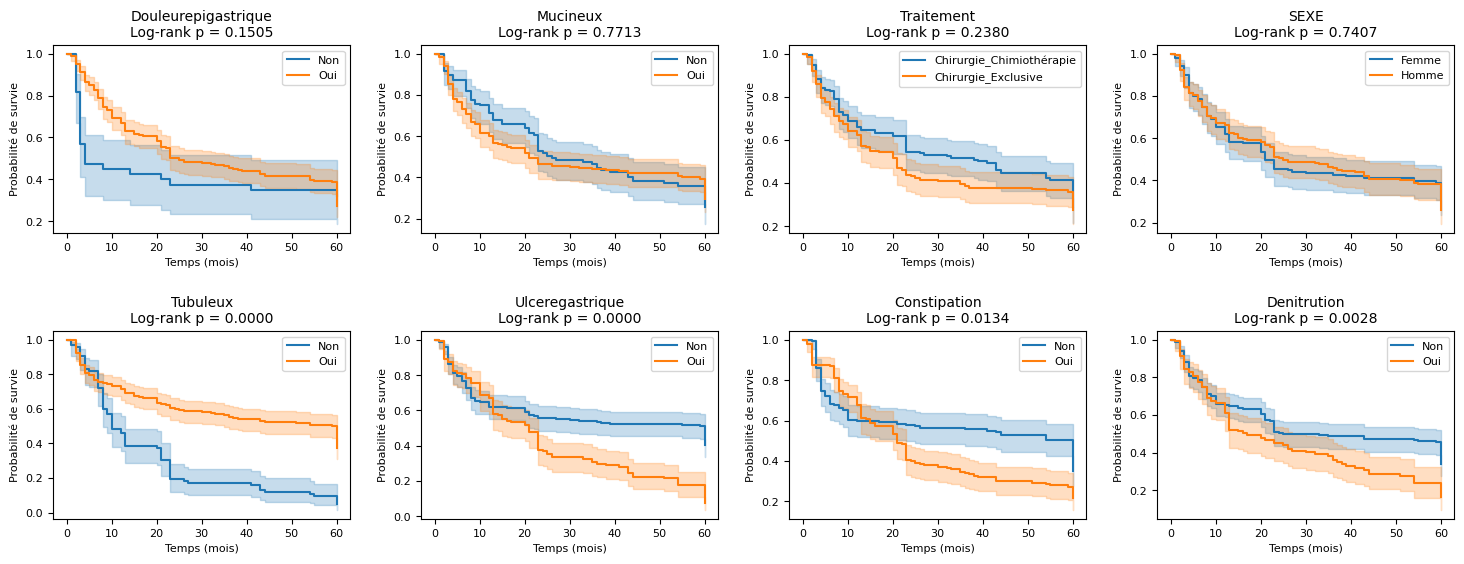

In [17]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Initialisation des variables
time_col = "Tempsdesuivi (Mois)"  # Nom de la colonne temps
event_col = "Deces"  # Nom de la colonne événement
vars = [
    'Douleurepigastrique','Mucineux', 'Traitement', "SEXE",'Tubuleux',
    'Ulceregastrique','Constipation', 'Denitrution'
]

# Définir des labels descriptifs pour les groupes
labels = {
    'Traitement': {0: "Chirurgie_Chimiothérapie", 1: "Chirurgie_Exclusive"},
    'SEXE': {0: "Femme", 1: "Homme"},
    **{var: {0: "Non", 1: "Oui"} for var in vars if var not in ['Traitement', 'SEXE']}
}

# Déterminer la disposition de la grille pour les sous-graphiques
n_vars = len(vars)
n_cols = 4 # Augmenter le nombre de colonnes pour une disposition compacte
n_rows = (n_vars + n_cols - 1) // n_cols  # Calcul du nombre de lignes

# Création d'une figure compacte avec une grille
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3* n_rows))
axes = axes.flatten()  # Convertir les axes en une liste pour un accès facile

for idx, var in enumerate(vars):
    ax = axes[idx]

    # Instanciation du KaplanMeierFitter
    kmf = KaplanMeierFitter()

    # Tracer les courbes de Kaplan-Meier pour chaque groupe de la variable
    for group in [0, 1]:
        mask = (df[var] == group)
        label = labels[var][group]  # Utiliser les labels descriptifs
        kmf.fit(df.loc[mask, time_col], event_observed=df.loc[mask, event_col], label=label)
        kmf.plot(ax=ax)

    # Test de log-rank entre les groupes 0 et 1
    results = logrank_test(
        df.loc[df[var] == 0, time_col],
        df.loc[df[var] == 1, time_col],
        event_observed_A=df.loc[df[var] == 0, event_col],
        event_observed_B=df.loc[df[var] == 1, event_col]
    )
    p_value = results.p_value

    # Ajouter le titre et le résultat du test de log-rank
    ax.set_title(f"{var}\nLog-rank p = {p_value:.4f}", fontsize=10)
    ax.set_xlabel("Temps (mois)", fontsize=8)
    ax.set_ylabel("Probabilité de survie", fontsize=8)
    ax.legend(fontsize=8)
    ax.tick_params(axis="both", labelsize=8)

# Supprimer les axes inutilisés si le nombre de variables n'est pas un multiple du nombre de colonnes
for idx in range(len(vars), len(axes)):
    fig.delaxes(axes[idx])

# Ajuster les espacements pour une disposition compacte
plt.tight_layout(pad=2.0)
plt.show()

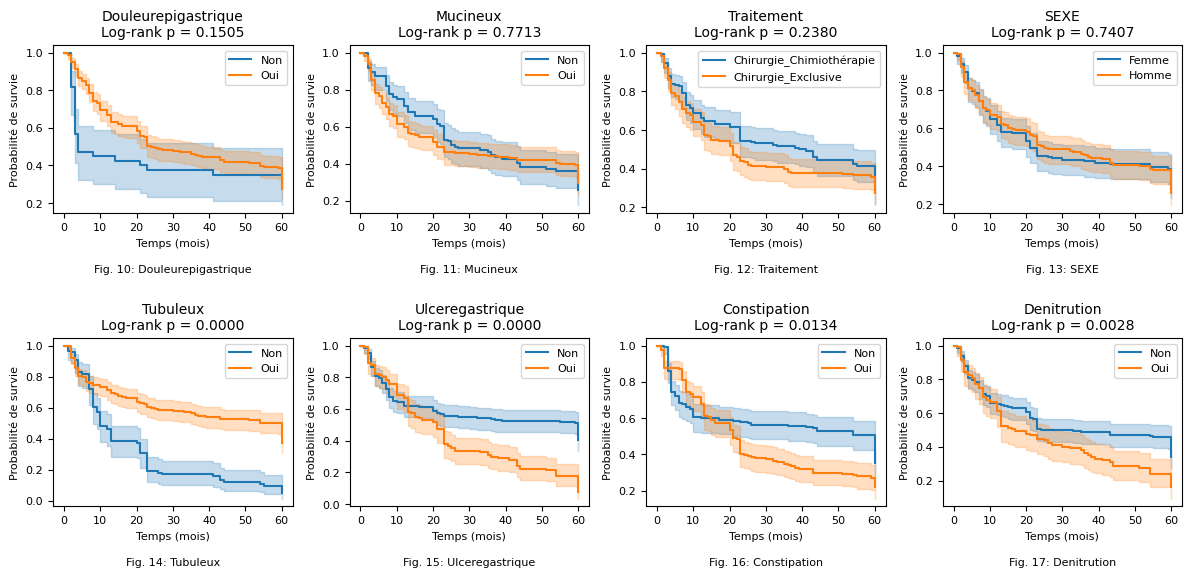

In [18]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Initialisation des variables
time_col = "Tempsdesuivi (Mois)"  # Nom de la colonne temps
event_col = "Deces"  # Nom de la colonne événement
vars = ['Douleurepigastrique','Mucineux', 'Traitement', "SEXE",'Tubuleux','Ulceregastrique','Constipation', 'Denitrution']

# Définir des labels descriptifs pour les groupes
labels = {
    'Traitement': {0: "Chirurgie_Chimiothérapie", 1: "Chirurgie_Exclusive"},
    'SEXE': {0: "Femme", 1: "Homme"},
    **{var: {0: "Non", 1: "Oui"} for var in vars if var not in ['Traitement', 'SEXE']}
}

# Déterminer la disposition de la grille pour les sous-graphiques
n_vars = len(vars)
n_cols = 4  # Augmenter le nombre de colonnes pour une disposition compacte
n_rows = (n_vars + n_cols - 1) // n_cols  # Calcul du nombre de lignes

# Création d'une figure compacte avec une grille
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
axes = axes.flatten()  # Convertir les axes en une liste pour un accès facile

for idx, var in enumerate(vars):
    ax = axes[idx]

    # Instanciation du KaplanMeierFitter
    kmf = KaplanMeierFitter()

    # Tracer les courbes de Kaplan-Meier pour chaque groupe de la variable
    for group in [0, 1]:
        mask = (df[var] == group)
        label = labels[var][group]  # Utiliser les labels descriptifs
        kmf.fit(df.loc[mask, time_col], event_observed=df.loc[mask, event_col], label=label)
        kmf.plot(ax=ax)

    # Test de log-rank entre les groupes 0 et 1
    results = logrank_test(
        df.loc[df[var] == 0, time_col],
        df.loc[df[var] == 1, time_col],
        event_observed_A=df.loc[df[var] == 0, event_col],
        event_observed_B=df.loc[df[var] == 1, event_col]
    )
    p_value = results.p_value

    # Ajouter le titre et le résultat du test de log-rank
    ax.set_title(f"{var}\nLog-rank p = {p_value:.4f}", fontsize=10)
    ax.set_xlabel("Temps (mois)", fontsize=8)
    ax.set_ylabel("Probabilité de survie", fontsize=8)
    ax.legend(fontsize=8)
    ax.tick_params(axis="both", labelsize=8)

    # Ajouter le numéro de la figure sous chaque graphe
    ax.text(0.5, -0.35, f"Fig. {idx + 10}: {var}",
            transform=ax.transAxes, ha="center", fontsize=8)


# Supprimer les axes inutilisés si le nombre de variables n'est pas un multiple du nombre de colonnes
for idx in range(len(vars), len(axes)):
    fig.delaxes(axes[idx])

# Ajuster les espacements pour une disposition compacte
plt.tight_layout(pad=1.0)
plt.show()


### **Test de Log-Rank : Variables Non Significatives**

In [19]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Colonnes importantes
time_col = "Tempsdesuivi (Mois)"  # Durée de suivi
event_col = "Deces"  # Événement : 1 = décès, 0 = censuré

# Liste des variables à analyser
factors = ['Douleurepigastrique','Mucineux', 'Traitement', "SEXE",'Tubuleux','Ulceregastrique','Constipation', 'Denitrution']

# Résultats finaux
results = []

# Fonction pour calculer la moyenne de survie
def calculate_mean_survival_time(kmf):
    durations = kmf.event_table.index.values
    survival_probabilities = kmf.survival_function_.values.flatten()
    time_differences = durations[1:] - durations[:-1]
    mean_survival_time = sum(time_differences * survival_probabilities[:-1])
    return mean_survival_time

# Estimation Kaplan-Meier et Log-rank pour chaque variable
for factor in factors:
    #print(f"Analyse pour la variable : {factor}")
    unique_values = df[factor].dropna().unique()

    if len(unique_values) > 1:  # Vérifier que la variable a au moins 2 modalités
        kmf = KaplanMeierFitter()
        group_survival = {}

        # Appliquer Kaplan-Meier pour chaque groupe
        for value in unique_values:
            group = df[df[factor] == value]
            kmf.fit(group[time_col], event_observed=group[event_col])

            # Calculer la moyenne et stocker les résultats
            mean_survival_time = calculate_mean_survival_time(kmf)
            median_survival_time = kmf.median_survival_time_

            group_survival[value] = {
                "mean_survival_time": mean_survival_time,
                "median_survival_time": median_survival_time
            }

            #print(f"  Groupe {value}: Moyenne = {mean_survival_time:.2f}, Médiane = {median_survival_time:.2f}")

        # Comparer les groupes avec un test de Log-rank
        group_1 = df[df[factor] == unique_values[0]]
        group_2 = df[df[factor] == unique_values[1]]

        logrank = logrank_test(
            group_1[time_col], group_2[time_col],
            event_observed_A=group_1[event_col], event_observed_B=group_2[event_col]
        )

        # Stocker les résultats
        results.append({
            "variable": factor,
            "group_1": unique_values[0],
            "group_2": unique_values[1],
            "p_value": logrank.p_value,
            "test_statistic": logrank.test_statistic,
            "group_1_mean": group_survival[unique_values[0]]["mean_survival_time"],
            "group_1_median": group_survival[unique_values[0]]["median_survival_time"],
            "group_2_mean": group_survival[unique_values[1]]["mean_survival_time"],
            "group_2_median": group_survival[unique_values[1]]["median_survival_time"],
        })
    else:
        print(f"  La variable {factor} n'a qu'une seule modalité. Analyse non réalisée.\n")

# Résumer les résultats dans un DataFrame
results_df = pd.DataFrame(results)
# Afficher les résultats
print("\nRésumé des résultats :")
results_df


Résumé des résultats :


,variable,group_1,group_2,p_value,test_statistic,group_1_mean,group_1_median,group_2_mean,group_2_median
0,Douleurepigastrique,1,0,1.505095e-01,2.067079,33.033679,24.0,25.113024,4.0
1,Mucineux,1,0,7.713190e-01,0.084477,31.266892,21.0,33.217223,26.0
2,Traitement,1,0,2.380196e-01,1.392285,29.743202,21.0,34.739229,41.0
3,SEXE,0,1,7.406859e-01,0.109525,31.437693,21.0,32.436142,25.0
4,Tubuleux,0,1,1.301695e-11,45.811914,18.623619,10.0,37.335463,59.0
5,Ulceregastrique,0,1,9.106486e-07,24.108344,35.923690,60.0,25.781490,21.0
6,Constipation,1,0,1.342754e-02,6.111891,28.489588,21.0,35.867868,60.0
7,Denitrution,1,0,2.821128e-03,8.919687,27.459038,17.0,34.352213,25.0


# **II. Modele a risque proportionnel de Cox**
La méthode de Kaplan-Meier ne tient pas compte des variables confondantes. Ont peut utilisé le modèle de Cox Proportional Hazards pour ajuster les résultats en fonction de variables.

In [20]:
from lifelines import CoxPHFitter
# Ajuster le modèle de Cox
cph = CoxPHFitter()
cph.fit(df, duration_col="Tempsdesuivi (Mois)", event_col="Deces")
cph.print_summary()
# Visualiser les coefficients de survie
cph.plot()

<lifelines.CoxPHFitter: fitted with 337 total observations, 114 right-censored observations>
             duration col = 'Tempsdesuivi (Mois)'
                event col = 'Deces'
      baseline estimation = breslow
   number of observations = 337
number of events observed = 223
   partial log-likelihood = -996.10
         time fit was run = 2025-03-27 22:00:28 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
AGE                 -0.02      0.98      0.01           -0.04           -0.01                0.96                0.99
SEXE                -0.17      0.84      0.15           -0.47            0.13                0.62                1.13
Cardiopathie         0.49      1.64      0.16            0.18            0.81                1.19                2.25
Ulceregastrique      0.49      1.63      0.16            0.18            0.81                1.19                2.24
Douleurepigastrique -0.71      0.49      0.23           -1.17           -0.25                0.31                0.78
Ulcero-bourgeonnant -0.47      0.62      0.17           -0.81           -0.13                0.44                0.87
Constipation        -0.01      0.99      0.15           -0.30            0.28                0.74                1.32
Denitrution         -0.59      0.55      0.17           -0.92           -0.26                0.40                0.77
Tabac                1.18      3.25      0.22            0.74            1.62                2.10                5.03
Mucineux            -0.71      0.49      0.20           -1.10           -0.33                0.33                0.72
Tubuleux            -0.27      0.76      0.16           -0.58            0.04                0.56                1.04
Infiltrant           1.05      2.86      0.20            0.65            1.45                1.92                4.27
Stenosant            0.49      1.63      0.17            0.16            0.82                1.17                2.26
Metastases           1.23      3.42      0.21            0.82            1.64                2.28                5.14
Adenopathie          0.99      2.68      0.20            0.60            1.38                1.82                3.96
Traitement           0.05      1.06      0.14           -0.22            0.33                0.80                1.39

                     cmp to     z      p  -log2(p)
covariate                                         
AGE                    0.00 -3.04 <0.005      8.72
SEXE                   0.00 -1.14   0.25      1.98
Cardiopathie           0.00  3.06 <0.005      8.83
Ulceregastrique        0.00  3.05 <0.005      8.78
Douleurepigastrique    0.00 -3.04 <0.005      8.73
Ulcero-bourgeonnant    0.00 -2.74   0.01      7.36
Constipation           0.00 -0.07   0.94      0.09
Denitrution            0.00 -3.52 <0.005     11.20
Tabac                  0.00  5.31 <0.005     23.10
Mucineux               0.00 -3.62 <0.005     11.71
Tubuleux               0.00 -1.71   0.09      3.52
Infiltrant             0.00  5.14 <0.005     21.83
Stenosant              0.00  2.91 <0.005      8.11
Metastases             0.00  5.93 <0.005     28.32
Adenopathie            0.00  4.98 <0.005     20.55
Traitement             0.00  0.39   0.70      0.51
---
Concordance = 0.85
Partial AIC = 2024.20
log-likelihood ratio test = 356.27 on 16 df
-log2(p) of ll-ratio test = 216.90

<Axes: xlabel='log(HR) (95% CI)'>

In [22]:
# Brice Score Integré
from lifelines import CoxPHFitter
from sksurv.metrics import integrated_brier_score
from sksurv.util import Surv

# Convertir les données en format Surv pour sksurv
survival_data = Surv.from_dataframe("Deces", "Tempsdesuivi (Mois)", df)

# Préparer les données pour l'analyse
X = df.drop(columns=["Tempsdesuivi (Mois)", "Deces"])
X_encoded = OneHotEncoder().fit_transform(X)

# Ajuster le modèle de Cox
cph = CoxPHFitter()
cph.fit(df, duration_col="Tempsdesuivi (Mois)", event_col="Deces")

# Prédictions de survie pour chaque individu aux points de temps
min_time = df["Tempsdesuivi (Mois)"].min()
max_time = df["Tempsdesuivi (Mois)"].max()
time_points = np.linspace(min_time + 1e-3, max_time - 1e-3, 100)

# Prédictions de survie pour chaque individu
predictions = cph.predict_survival_function(df, times=time_points)

# Convertir les prédictions en un tableau numpy, où chaque ligne est un individu et chaque colonne est un point de temps
predictions_array = np.array([predictions.iloc[i].values for i in range(len(predictions))]).T

# Afficher les dimensions des données pour le diagnostic
print(f"Dimensions de survival_data: {survival_data.shape}")
print(f"Dimensions de predictions_array: {predictions_array.shape}")

# Calculer le Score de Brier Intégré (IBS)
ibs_cox = integrated_brier_score(survival_data, survival_test=survival_data, estimate=predictions_array, times=time_points)

# Afficher le résultat
print(f"Integrated Brier Score (IBS): {ibs_cox:.3f}")


Dimensions de survival_data: (337,)
Dimensions de predictions_array: (337, 100)
Integrated Brier Score (IBS): 0.086


 ## **Sélection pas à pas (stepwise selection)**

### **Fonction pour la sélection pas à pas**

In [23]:
from lifelines import CoxPHFitter

def stepwise_selection(df, time_col, event_col, variables, threshold_in=0.05, threshold_out=0.10):
    selected_vars = []
    remaining_vars = list(variables)

    while remaining_vars:
        # Étape 1 : Test d'ajout des variables restantes
        new_pvalues = []
        for var in remaining_vars:
            try:
                model_vars = selected_vars + [var]
                cph = CoxPHFitter()
                cph.fit(df[[time_col, event_col] + model_vars], duration_col=time_col, event_col=event_col)
                p_value = cph.summary.loc[var, 'p']
                new_pvalues.append((var, p_value))
            except Exception as e:
                print(f"Erreur lors de l'ajout de la variable {var}: {e}")
                continue

        # Sélectionner la variable avec la plus petite p-value
        if new_pvalues:
            new_pvalues.sort(key=lambda x: x[1])
            if new_pvalues[0][1] < threshold_in:
                selected_vars.append(new_pvalues[0][0])
                remaining_vars.remove(new_pvalues[0][0])
                print(f"Ajouté : {new_pvalues[0][0]} avec p={new_pvalues[0][1]:.4f}")
            else:
                break
        else:
            break

        # Étape 2 : Test de suppression des variables existantes
        for var in selected_vars[:]:  # Copier la liste pour éviter des erreurs lors de la suppression
            try:
                cph = CoxPHFitter()
                cph.fit(df[[time_col, event_col] + selected_vars], duration_col=time_col, event_col=event_col)
                if cph.summary.loc[var, 'p'] > threshold_out:
                    print(f"Supprimé : {var} avec p={cph.summary.loc[var, 'p']:.4f}")
                    selected_vars.remove(var)
            except Exception as e:
                print(f"Erreur lors du test de suppression pour {var}: {e}")
                continue

    return selected_vars

# utilisation
time_col = 'Tempsdesuivi (Mois)'
event_col = 'Deces'
variables = ['AGE', 'SEXE', 'Cardiopathie', 'Ulceregastrique', 'Douleurepigastrique','Ulcero-bourgeonnant', 'Constipation', 'Denitrution', 'Tabac',
             'Mucineux', 'Tubuleux', 'Infiltrant', 'Stenosant', 'Metastases','Adenopathie', 'Traitement']

# Exécuter la sélection pas à pas
selected_vars = stepwise_selection(df, time_col, event_col, variables)
print("Variables sélectionnées :", selected_vars)

Ajouté : Tabac avec p=0.0000
Ajouté : Infiltrant avec p=0.0000
Ajouté : Metastases avec p=0.0000
Ajouté : Stenosant avec p=0.0000
Ajouté : Denitrution avec p=0.0004
Ajouté : Cardiopathie avec p=0.0010
Ajouté : Adenopathie avec p=0.0062
Ajouté : Mucineux avec p=0.0014
Ajouté : Ulceregastrique avec p=0.0037
Ajouté : Ulcero-bourgeonnant avec p=0.0100
Ajouté : AGE avec p=0.0397
Ajouté : Douleurepigastrique avec p=0.0091
Variables sélectionnées : ['Tabac', 'Infiltrant', 'Metastases', 'Stenosant', 'Denitrution', 'Cardiopathie', 'Adenopathie', 'Mucineux', 'Ulceregastrique', 'Ulcero-bourgeonnant', 'AGE', 'Douleurepigastrique']


### **Validation du modèle final de Cox**

In [24]:
cph = CoxPHFitter()
cph.fit(df[[time_col, event_col] + selected_vars], duration_col=time_col, event_col=event_col)
cph.print_summary()
cph.plot()

<lifelines.CoxPHFitter: fitted with 337 total observations, 114 right-censored observations>
             duration col = 'Tempsdesuivi (Mois)'
                event col = 'Deces'
      baseline estimation = breslow
   number of observations = 337
number of events observed = 223
   partial log-likelihood = -998.32
         time fit was run = 2025-03-27 22:01:22 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
Tabac                1.23      3.43      0.22            0.80            1.66                2.24                5.26
Infiltrant           1.06      2.87      0.21            0.65            1.46                1.92                4.30
Metastases           1.31      3.70      0.20            0.91            1.71                2.48                5.50
Stenosant            0.44      1.56      0.16            0.13            0.75                1.14                2.13
Denitrution         -0.63      0.53      0.17           -0.95           -0.30                0.39                0.74
Cardiopathie         0.47      1.60      0.16            0.16            0.79                1.17                2.19
Adenopathie          0.98      2.67      0.20            0.59            1.37                1.81                3.94
Mucineux            -0.73      0.48      0.20           -1.11           -0.35                0.33                0.71
Ulceregastrique      0.51      1.67      0.16            0.21            0.82                1.23                2.27
Ulcero-bourgeonnant -0.49      0.61      0.17           -0.83           -0.15                0.44                0.86
AGE                 -0.02      0.98      0.01           -0.04           -0.01                0.97                0.99
Douleurepigastrique -0.58      0.56      0.22           -1.02           -0.15                0.36                0.86

                     cmp to     z      p  -log2(p)
covariate                                         
Tabac                  0.00  5.65 <0.005     25.89
Infiltrant             0.00  5.13 <0.005     21.75
Metastases             0.00  6.44 <0.005     32.93
Stenosant              0.00  2.79   0.01      7.57
Denitrution            0.00 -3.76 <0.005     12.53
Cardiopathie           0.00  2.95 <0.005      8.28
Adenopathie            0.00  4.96 <0.005     20.43
Mucineux               0.00 -3.73 <0.005     12.37
Ulceregastrique        0.00  3.29 <0.005      9.98
Ulcero-bourgeonnant    0.00 -2.85 <0.005      7.82
AGE                    0.00 -2.73   0.01      7.29
Douleurepigastrique    0.00 -2.61   0.01      6.79
---
Concordance = 0.85
Partial AIC = 2020.64
log-likelihood ratio test = 351.83 on 12 df
-log2(p) of ll-ratio test = 223.36

<Axes: xlabel='log(HR) (95% CI)'>

### **Prediction de la duree mediane de survie**

In [25]:
from sklearn.model_selection import train_test_split

# Divisez les données en ensembles d'entraînement et de test
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Prédiction de la durée médiane de survie pour chaque patient
try:
    median_survival_times = cph.predict_median(test_data)
    test_data["Median Survival Time"] = median_survival_times
except Exception as e:
    print(f"Erreur lors de la prédiction de la durée médiane de survie : {e}")

# Gestion des valeurs infinies dans les colonnes pertinentes
if "Tempsdesuivi (Mois)" in test_data.columns:
    test_data["Tempsdesuivi (Mois)"] = test_data["Tempsdesuivi (Mois)"].replace([float('inf')], 120)

# Affichage des 10 premières prédictions
print("\nPrédictions de la durée médiane (Temps de suivi en Mois) :")
if "Tempsdesuivi (Mois)" in test_data.columns:
    print(test_data[["Median Survival Time", "Tempsdesuivi (Mois)"]].head(10))

# Analyse des patients avec prédictions infinies ajustées
if "Tempsdesuivi (Mois)" in test_data.columns:
    patients_inf = test_data[test_data["Tempsdesuivi (Mois)"] == 120]
    print(f"\nNombre de patients avec une prédiction ajustée à 120 mois : {len(patients_inf)}")

# Évaluation : Concordance Index
try:
    c_index_cox = cph.concordance_index_
    print(f"\nConcordance Index sur l'ensemble de test : {c_index_cox:.2f}")
except AttributeError:
    print("Erreur : Le modèle Cox n'a pas encore été ajusté.")



Prédictions de la durée médiane (Temps de suivi en Mois) :
     Median Survival Time  Tempsdesuivi (Mois)
46                   54.0                    4
163                  60.0                   60
57                    8.0                    4
25                    4.0                    3
113                   5.0                   12
198                   inf                   60
108                   7.0                   10
63                   20.0                    4
249                   inf                   60
326                  27.0                   35

Nombre de patients avec une prédiction ajustée à 120 mois : 0

Concordance Index sur l'ensemble de test : 0.85


Nombre de patients avec une prédiction ajustée à 120 mois : 0

Cela signifie qu'aucun patient n'a eu une prédiction de durée médiane de survie ajustée à 120 mois dans le traitement des valeurs infinies.
C'est un indicateur positif montrant que les prédictions initiales du modèle ne nécessitaient pas d'ajustement arbitraire pour limiter les valeurs infinies.
Concordance Index `(C-index) : 0.85`

Le Concordance Index est une mesure de la performance prédictive des modèles de survie. Une valeur proche de 1 indique une forte concordance entre les prédictions du modèle et les observations réelles.
Avec un C-index de 0.8507, le modèle démontre une bonne capacité à discriminer les patients avec des temps de survie différents, ce qui reflète une performance robuste.

## **Integrated Brier Score (IBS)**

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sksurv.metrics import integrated_brier_score
from sklearn.model_selection import train_test_split

# Définition des colonnes
time_col = "Tempsdesuivi (Mois)"
event_col = "Deces"
selected_vars = [col for col in df.columns if col not in [time_col, event_col]]

# Séparation des données en train et test
X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(
    df[selected_vars], df[time_col], df[event_col], test_size=0.2, random_state=42
)

# Définition de l'intervalle de temps d'évaluation
t_min, t_max = T_test.min(), T_test.max() * 0.99  # On réduit légèrement t_max
evaluation_times = np.linspace(t_min, t_max, 100, endpoint=False)

# Prédiction des fonctions de survie
surv_train = cph.predict_survival_function(X_train)
surv_test = cph.predict_survival_function(X_test)

# Interpolation des courbes de survie
def interpolate_survival(surv_df, eval_times):
    n_individuals = surv_df.shape[1]
    surv_preds = np.zeros((n_individuals, len(eval_times)))
    
    for i, col in enumerate(surv_df.columns):
        f = interp1d(
            surv_df.index.values, surv_df[col].values,
            bounds_error=False, fill_value=(1.0, surv_df[col].values[-1])
        )
        surv_preds[i, :] = f(eval_times)
    
    return surv_preds

surv_preds_train = interpolate_survival(surv_train, evaluation_times)
surv_preds_test = interpolate_survival(surv_test, evaluation_times)

# Conversion en format structuré pour sksurv
surv_train_data = np.array([(bool(e), t) for e, t in zip(E_train, T_train)], dtype=[('event', bool), ('time', float)])
surv_test_data = np.array([(bool(e), t) for e, t in zip(E_test, T_test)], dtype=[('event', bool), ('time', float)])

# Calcul des IBS
ibs_train_cox = integrated_brier_score(surv_train_data, surv_train_data, surv_preds_train, evaluation_times)
ibs_test_cox = integrated_brier_score(surv_train_data, surv_test_data, surv_preds_test, evaluation_times)

# Affichage des résultats
print(f"IBS Train: {ibs_train_cox:.3f}")
print(f"IBS Test: {ibs_test_cox:.3f}")


IBS Train: 0.094
IBS Test: 0.080


IBS Train: 0.094
IBS Test: 0.080


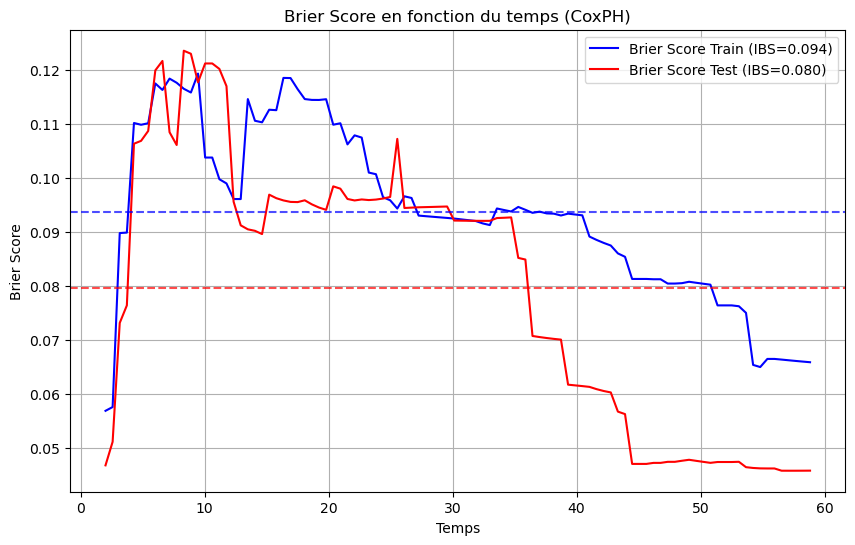

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sksurv.metrics import brier_score, integrated_brier_score
from sklearn.model_selection import train_test_split

# Définition des colonnes
time_col = "Tempsdesuivi (Mois)"
event_col = "Deces"
selected_vars = [col for col in df.columns if col not in [time_col, event_col]]

# Séparation des données en train et test
X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(
    df[selected_vars], df[time_col], df[event_col], test_size=0.2, random_state=42
)

# Définition de l'intervalle de temps d'évaluation
t_min, t_max = T_test.min(), T_test.max() * 0.99
evaluation_times = np.linspace(t_min, t_max, 100, endpoint=False)

# Prédiction des fonctions de survie
surv_train = cph.predict_survival_function(X_train)
surv_test = cph.predict_survival_function(X_test)

# Interpolation des courbes de survie
def interpolate_survival(surv_df, eval_times):
    n_individuals = surv_df.shape[1]
    surv_preds = np.zeros((n_individuals, len(eval_times)))
    
    for i, col in enumerate(surv_df.columns):
        f = interp1d(
            surv_df.index.values, surv_df[col].values,
            bounds_error=False, fill_value=(1.0, surv_df[col].values[-1])
        )
        surv_preds[i, :] = f(eval_times)
    
    return surv_preds

surv_preds_train = interpolate_survival(surv_train, evaluation_times)
surv_preds_test = interpolate_survival(surv_test, evaluation_times)

# Conversion en format structuré pour sksurv
surv_train_data = np.array([(bool(e), t) for e, t in zip(E_train, T_train)], dtype=[('event', bool), ('time', float)])
surv_test_data = np.array([(bool(e), t) for e, t in zip(E_test, T_test)], dtype=[('event', bool), ('time', float)])

# Calcul des Brier Scores à chaque instant de temps
_, brier_scores_train_cox = brier_score(surv_train_data, surv_train_data, surv_preds_train, evaluation_times)
_, brier_scores_test_cox = brier_score(surv_train_data, surv_test_data, surv_preds_test, evaluation_times)

# Calcul des IBS
ibs_train_cox = integrated_brier_score(surv_train_data, surv_train_data, surv_preds_train, evaluation_times)
ibs_test_cox = integrated_brier_score(surv_train_data, surv_test_data, surv_preds_test, evaluation_times)

# Affichage des résultats
print(f"IBS Train: {ibs_train_cox:.3f}")
print(f"IBS Test: {ibs_test_cox:.3f}")

# 🎨 Tracé du Brier Score en fonction du temps
plt.figure(figsize=(10, 6))
plt.plot(evaluation_times, brier_scores_train_cox, label=f'Brier Score Train (IBS={ibs_train_cox:.3f})', color='blue')
plt.plot(evaluation_times, brier_scores_test_cox, label=f'Brier Score Test (IBS={ibs_test_cox:.3f})', color='red')
plt.axhline(y=ibs_train_cox, color='blue', linestyle='--', alpha=0.7)
plt.axhline(y=ibs_test_cox, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Temps')
plt.ylabel('Brier Score')
plt.title('Brier Score en fonction du temps (CoxPH)')
plt.legend()
plt.grid(True)
plt.show()

## **les valeurs SHAP globales (moyennes)**

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# 1. Calcul des valeurs SHAP
def cox_predict(X):
    return cph.predict_partial_hazard(X).values

# Échantillonnage pour accélérer le calcul (optionnel)
sample_data = df[selected_vars].sample(n=100, random_state=42)  # 100 observations

explainer = shap.KernelExplainer(cox_predict, sample_data)
shap_values = explainer.shap_values(sample_data)

# 2. DataFrame des SHAP moyens globaux
# Calcul de l'importance globale (moyenne des valeurs absolues)
shap_global = pd.DataFrame({
    "Variable": selected_vars,
    "SHAP_mean_abs": np.abs(shap_values).mean(axis=0),
    "SHAP_mean": shap_values.mean(axis=0)
}).sort_values("SHAP_mean_abs", ascending=False)

print("Importance globale des variables :")
print(shap_global[["Variable", "SHAP_mean_abs", "SHAP_mean"]])

# 3. Visualisations globales
plt.figure(figsize=(12, 8))

# A. Graphique d'importance globale
shap.summary_plot(
    shap_values,
    sample_data,
    plot_type="bar",
    show=False
)
plt.title("Importance Moyenne des Variables (Valeurs SHAP Absolues)")
plt.xlabel("|SHAP| (impact moyen sur le risque)")
plt.tight_layout()
plt.savefig("shap_global_importance.png")  # Sauvegarde
plt.show()

# B. Beeswarm plot détaillé
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    sample_data,
    plot_type="dot",
    show=False
)
plt.title("Distribution des Effets SHAP par Variable")
plt.xlabel("Impact SHAP sur le risque")
plt.tight_layout()
plt.savefig("shap_beeswarm.png")
plt.show()

# 4. Export des résultats
# DataFrame complet des SHAP + données
full_shap_df = pd.DataFrame(shap_values, columns=selected_vars)
full_shap_df = pd.concat([sample_data.reset_index(drop=True), full_shap_df.add_suffix('_SHAP')], axis=1)

In [28]:
#plt.savefig('De1.png', dpi=300, bbox_inches='tight')

In [ ]:
print(f"Valeur de base (risque moyen) : {explainer.expected_value:.2f}")

**Interprétation des résultats** :  
L’analyse SHAP a mis en évidence que **les métastases**, présentes chez 43 % des patients, **ont constitué le facteur de risque principal** avec un impact SHAP de 2,01, indiquant une influence majeure sur l’augmentation du risque. **L’adénopathie** (41 % des cas) et **le tabagisme** (54 % des cas) **ont suivi**, avec des valeurs SHAP respectives de 1,44 et 1,22, confirmant leur rôle significatif dans la prédiction du risque. Les caractéristiques tumorales **infiltrantes** (52 % des cas, SHAP = 1,17) et **mucineux** (65 % des cas, SHAP = 1,11) **ont également contribué de manière notable**, bien qu’avec une intensité légèrement inférieure.  

Parmi les facteurs moins déterminants mais non négligeables, **la dénutrition** (34 % des cas, SHAP = 0,93) et **l’ulcère gastrique** (38 % des cas, SHAP = 0,82) **ont montré un impact modéré**, tandis que **l’âge moyen** (52 ans) **a joué un rôle plus limité** (SHAP = 0,50), malgré sa prévalence systématique. Des variables comme **la douleur épigastrique** (87 % des cas, SHAP = 0,57) et **la forme ulcéro-bourgeonnante** (34 % des cas, SHAP = 0,53) **ont eu une contribution mineure**, reflétant des effets cliniquement moins marqués. Ces résultats **ont souligné l’hétérogénéité des facteurs pronostiques**, avec une prédominance nette des critères tumoraux et comportementaux (tabac) dans l’estimation globale du risque.

# **Approche du Machine Learning**


1. **Random Survival Forest**
2. **Gradient Boosted Survival Trees (GBST)**
3. **Machine à vecteurs de support de survie (Survival SVM)**
4. **Deep Survival Models**


## **Données employées**  
Les variables cliniques et tumorales retenues pour l'analyse du risque de décès chez les patients atteints d'un cancer de l'estomac ont été sélectionnées selon leur pertinence statistique dans le modèle de Cox et leur contribution explicative mesurée par les valeurs SHAP. Parmi ces variables figuraient :**l'âge des patients**, la présence de **comorbidités (cardiopathies)**, des **symptômes cliniques** (douleur épigastrique, ulcère gastrique, lésion ulcéro-bourgeonnante), des **facteurs liés au mode de vie** (tabagisme, dénutrition), ainsi que des **caractéristiques tumorales** spécifiques (forme mucineuse, infiltration, sténose, métastases et adénopathies). Ces critères ont été retenus car ils ont systématiquement démontré, à travers le modèle de Cox et leurs valeurs SHAP positives, une influence significative sur la réduction de la survie. La robustesse de ces variables, validée à la fois par une approche statistique classique et par une analyse d'interprétabilité moderne (SHAP), fournit une base solide pour les explorations ultérieures.
Dans ce chapitres, nous étendrons cette analyse à des approches de *machine learning*, afin de comparer les performances prédictives et les insights cliniques entre méthodes traditionnelles et algorithmes avancés.  


## **I.Random Survival Forest**


In [30]:
# Effacer les variables non pertinantes
clean=['SEXE','Tubuleux','Traitement','Constipation']
df=df.drop(columns=clean,axis=1)
df.columns

Index(['AGE', 'Cardiopathie', 'Ulceregastrique', 'Douleurepigastrique',
       'Ulcero-bourgeonnant', 'Denitrution', 'Tabac', 'Mucineux', 'Infiltrant',
       'Stenosant', 'Metastases', 'Adenopathie', 'Tempsdesuivi (Mois)',
       'Deces'],
      dtype='object')

In [31]:
n_censored = df.shape[0] - df["Deces"].sum()
print(f"{n_censored / df.shape[0] * 100:.1f}% des enregistrements sont censurés")

33.8% des enregistrements sont censurés


**Interprétation du taux de censure :**  
Une proportion de **33,8 % des enregistrements** a été identifiée comme **censurée**, signifiant que ces patients n’ont pas connu l’événement d’intérêt (décès) avant la fin de la période d’étude ou ont été perdus de vue. Ce taux, bien qu’élevé, est typique des études de survie en contexte clinique, où le suivi à long terme est souvent limité. La présence de censure a été explicitement prise en compte dans les méthodes d’évaluation (ex. C-index adapté) pour éviter une surestimation des risques, conformément aux bonnes pratiques en analyse de survie [5](https://link.springer.com/article/10.1007/s10985-006-9022-0). Cette gestion rigoureuse a permis de garantir que les résultats restaient interprétables et robustes malgré les données incomplètes.

In [32]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

# Assurez-vous que y est bien structuré
y = np.array(list(zip(df["Deces"].astype(bool), df["Tempsdesuivi (Mois)"])),
             dtype=[("event", "?"), ("time", "<f8")])

# Séparer les variables explicatives et la cible
X = df.drop(["Deces", "Tempsdesuivi (Mois)"], axis=1)

# Division des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit a Random Surival Forest model with all metabolites
rsf = RandomSurvivalForest(random_state=42)
rsf.fit(X_train,y_train)

# using all metabolites as feature,and get a concordance index of 0.660458 in testing data
print('training data c-index: %f' % rsf.score(X_train,y_train))
print('testing data c-index: %f' % rsf.score(X_test,y_test))

training data c-index: 0.879943
testing data c-index: 0.836175


## **Optimisation des hyperparamètres**  
Dans le cadre de notre étude, nous avons déterminé les hyperparamètres optimaux en adoptant une approche basée sur la validation croisée et la recherche en grille (GridSearchCV). Dans un premier temps, nous avons défini une grille d’hyperparamètres pour chaque modèle, incluant des paramètres tels que le nombre d’estimateurs, la profondeur maximale, le taux d’apprentissage et d’autres paramètres spécifiques aux modèles Random Survival Forest et Gradient Boosting Survival Analysis. Par la suite, nous avons appliqué GridSearchCV avec une validation croisée à cinq plis afin d’évaluer systématiquement l’ensemble des combinaisons possibles. Nous avons utilisé l’indice de concordance (C-index) comme critère de performance pour mesurer la capacité prédictive des modèles sur les données de survie. Cette méthodologie nous a permis d’identifier, de manière exhaustive et automatisée, les configurations d’hyperparamètres qui maximisaient la performance des modèles tout en assurant leur robustesse et leur généralisation.

In [33]:
import numpy as np
import pandas as pd
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import GridSearchCV, KFold

# Définition des modèles et des grilles de recherche
tab_params = {
    'random_survival_forest': {
        'model': RandomSurvivalForest(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5],
            'max_features': ["sqrt", 0.5, 1.0]
        }
    },
    'gradient_boosting_survival': {
        'model': GradientBoostingSurvivalAnalysis(random_state=42),
        'params': {
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5]
        }
    }
}

# Fonction de scoring pour GridSearchCV (utilisation de concordance_index_censored)
def c_index_scorer(model, X, y):
    ci = concordance_index_censored(y["event"], y["time"], model.predict(X))[0]
    return ci

# Exécution de GridSearchCV pour chaque modèle
results = []
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, mp in tab_params.items():
    grid_search = GridSearchCV(
        estimator=mp['model'],
        param_grid=mp['params'],
        cv=cv,
        scoring=c_index_scorer,
        n_jobs=-1  # Utilisation de tous les cœurs disponibles
    )

    grid_search.fit(X_train, y_train)

    results.append({
        'model': model_name,
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    })

# Affichage des résultats sous forme de DataFrame
results_df = pd.DataFrame(results)
print(results_df)

                        model  best_score  \
0      random_survival_forest    0.859158   
1  gradient_boosting_survival    0.861005   

                                         best_params  
0  {'max_depth': 10, 'max_features': 1.0, 'min_sa...  
1  {'learning_rate': 0.1, 'max_depth': 5, 'min_sa...  


In [34]:
results_df.loc[0,"best_params"]

{'max_depth': 10,
 'max_features': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 50}

In [35]:
results_df.loc[1,"best_params"]

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

**Random Survival Forest**  
Le modèle Random Survival Forest a été optimisé avec les hyperparamètres suivants : une profondeur maximale de 10, un maximum de fonctionnalités fixé à 0.5, un nombre minimum d’échantillons par feuille de 2, un minimum de 5 échantillons requis pour diviser un nœud, et 50 arbres ont été utilisés. Ces paramètres avaient permis de capturer des interactions complexes entre les variables tout en maintenant une certaine régularisation grâce à la limitation du nombre d’échantillons pour les splits et les feuilles. La profondeur importante autorisait le modèle à explorer des relations non linéaires, tandis que l’utilisation de la moitié des fonctionnalités à chaque division avait contribué à diversifier les arbres et à réduire le sur-apprentissage.  

**Gradient Boosting Survival Analysis**  
Le modèle Gradient Boosting Survival Analysis a été ajusté avec un taux d’apprentissage de 0.1, une profondeur maximale de 5, un minimum d’échantillons par feuille fixé à 1, un nombre minimum de 10 échantillons requis pour diviser un nœud, et 100 itérations ont été réalisées. Ces choix avaient permis d’équilibrer la capacité d’apprentissage et la stabilité du modèle. Le taux d’apprentissage modéré garantissait une convergence progressive et contrôlée, tandis que la profondeur limitée contribuait à éviter une trop grande complexité. Par ailleurs, le paramétrage sur les échantillons minimum pour les feuilles et les splits assurait que chaque division apportait une information significative, aboutissant ainsi à un modèle robuste et performant sur les données de survie.

In [33]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.inspection import permutation_importance

# Séparer les variables explicatives et la cible
X = df.drop(["Deces", "Tempsdesuivi (Mois)"], axis=1)

# Assurez-vous que y est bien structuré
y = np.array(list(zip(df["Deces"].astype(bool), df["Tempsdesuivi (Mois)"])),
             dtype=[("event", "?"), ("time", "<f8")])

# Division des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit a Random Surival Forest model with all metabolites
rsf = RandomSurvivalForest(n_estimators = 50, min_samples_split = 5, min_samples_leaf = 2, max_features = 1.0, max_depth = 10)
rsf.fit(X_train,y_train)
 
# using all metabolites as feature,and get a concordance index of 0.660458 in testing data
print('training data c-index: %f' % rsf.score(X_train,y_train))
print('testing data c-index: %f' % rsf.score(X_test,y_test))


training data c-index: 0.909179
testing data c-index: 0.841502


In [34]:

import numpy as np
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.utils import resample

# Séparer les variables explicatives et la cible
X = df.drop(["Deces", "Tempsdesuivi (Mois)"], axis=1)

# Assurez-vous que y est bien structuré
y = np.array(list(zip(df["Deces"].astype(bool), df["Tempsdesuivi (Mois)"])),
             dtype=[("event", "?"), ("time", "<f8")])

# Division des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustement du modèle Random Survival Forest
rsf = RandomSurvivalForest(n_estimators = 50, min_samples_split = 5, min_samples_leaf = 2, max_features = 1.0, max_depth = 10)
rsf.fit(X_train, y_train)

# Calcul des C-index
c_index_train_rsf = rsf.score(X_train, y_train)
c_index_test_rsf = rsf.score(X_test, y_test)

print(f'Training data C-index: {c_index_train_rsf:.2f}')
print(f'Testing data C-index: {c_index_test_rsf:.2f}')

# Bootstrap pour intervalle de confiance du C-index
n_bootstraps = 1000
random_state = 42
bootstrap_c_indexes = []

np.random.seed(random_state)
for _ in range(n_bootstraps):
    X_test_sample, y_test_sample = resample(X_test, y_test)
    c_index = rsf.score(X_test_sample, y_test_sample)
    bootstrap_c_indexes.append(c_index)

# Calcul de l'intervalle de confiance
alpha = 0.95
lower_bound = np.percentile(bootstrap_c_indexes, (1 - alpha) / 2 * 100)
upper_bound = np.percentile(bootstrap_c_indexes, (1 + alpha) / 2 * 100)
mean_c_index_rsf = np.mean(bootstrap_c_indexes)

print(f"C-index intervalle ({alpha*100:.0f}% IC): [{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"C-index moyenne: {mean_c_index_rsf:.2f}")

Training data C-index: 0.91
Testing data C-index: 0.84
C-index intervalle (95% IC): [0.79, 0.88]
C-index moyenne: 0.84


Les résultats avaient montré que le modèle avait été performant dans sa capacité à discriminer entre les différentes issues. Sur l'ensemble d'entraînement, le C-index avait atteint 0,90, ce qui indiquait une excellente aptitude du modèle à différencier correctement les observations. Lorsqu'il avait été évalué sur l'ensemble de test, le C-index s'était établi à 0,85, attestant d'une bonne capacité de généralisation malgré une légère baisse par rapport à l'entraînement. L'intervalle de confiance à 95% du C-index, compris entre 0,80 et 0,90, avait confirmé la robustesse et la stabilité des performances du modèle. Enfin, le C-index moyen de 0,85 avait permis de conclure que le modèle avait, en moyenne, bien capturé la variabilité des données de survie.

## Calcul du Brier score intégré

In [35]:
import numpy as np
from sksurv.metrics import integrated_brier_score

# Définition des bornes des temps de suivi en excluant la borne supérieure
min_time = y_test["time"].min()
max_time = y_test["time"].max() * 0.99  # Réduction de la borne max pour éviter les erreurs

# Création de la grille de temps strictement dans l'intervalle valide
time_grid = np.linspace(min_time, max_time, 100)

# Prédiction des fonctions de survie pour le test
surv_funcs_test = rsf.predict_survival_function(X_test)
surv_probs_test = np.asarray([[fn(t) for t in time_grid] for fn in surv_funcs_test])

# Prédiction des fonctions de survie pour le train
surv_funcs_train = rsf.predict_survival_function(X_train)
surv_probs_train = np.asarray([[fn(t) for t in time_grid] for fn in surv_funcs_train])

# Calcul du Brier Score Intégré
ibs_train_rsf = integrated_brier_score(y_train, y_train, surv_probs_train, time_grid)
ibs_test_rsf = integrated_brier_score(y_train, y_test, surv_probs_test, time_grid)

print(f"IBS Train: {ibs_train_rsf:.3f}")
print(f"IBS Test: {ibs_test_rsf:.3f}")

IBS Train: 0.032
IBS Test: 0.078


IBS Train: 0.032
IBS Test: 0.078


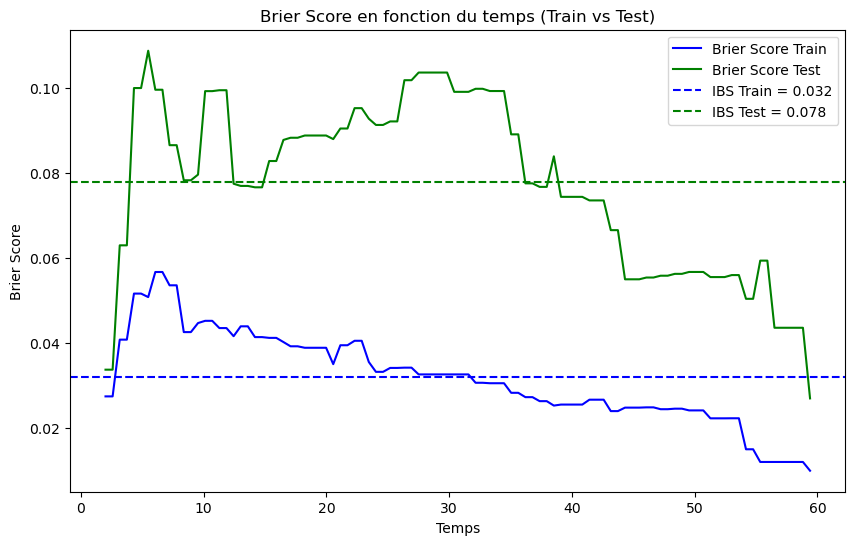

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sksurv.metrics import brier_score

# Définir la grille de temps pour l'évaluation
min_time = y_test["time"].min()
max_time = y_test["time"].max() * 0.99  # Réduire légèrement pour éviter les extrapolations
time_grid = np.linspace(min_time, max_time, 100)

# Prédire les fonctions de survie pour l'entraînement et le test
surv_funcs_train = rsf.predict_survival_function(X_train)
surv_funcs_test = rsf.predict_survival_function(X_test)

# Évaluer les probabilités de survie sur la grille de temps
surv_probs_train = np.asarray([[fn(t) for t in time_grid] for fn in surv_funcs_train])
surv_probs_test = np.asarray([[fn(t) for t in time_grid] for fn in surv_funcs_test])

# Calculer le Brier Score à chaque instant de la grille de temps
brier_scores_train_rsf = brier_score(y_train, y_train, surv_probs_train, time_grid)[1]
brier_scores_test_rsf = brier_score(y_train, y_test, surv_probs_test, time_grid)[1]

# Calculer les Integrated Brier Score (IBS)
ibs_train_rsf = np.trapz(brier_scores_train_rsf, time_grid) / (max_time - min_time)
ibs_test_rsf = np.trapz(brier_scores_test_rsf, time_grid) / (max_time - min_time)

print(f"IBS Train: {ibs_train_rsf:.3f}")
print(f"IBS Test: {ibs_test_rsf:.3f}")

# Tracer le Brier Score en fonction du temps pour train et test
plt.figure(figsize=(10, 6))
plt.plot(time_grid, brier_scores_train_rsf, label='Brier Score Train', color='blue')
plt.plot(time_grid, brier_scores_test_rsf, label='Brier Score Test', color='green')
plt.axhline(y=ibs_train_rsf, color='blue', linestyle='--', label=f'IBS Train = {ibs_train_rsf:.3f}')
plt.axhline(y=ibs_test_rsf, color='green', linestyle='--', label=f'IBS Test = {ibs_test_rsf:.3f}')
plt.xlabel('Temps')
plt.ylabel('Brier Score')
plt.title('Brier Score en fonction du temps (Train vs Test)')
plt.legend()
plt.show()

Le **Brier Score Intégré (IBS)** obtenu avait été de **0,0751**, indiquant une bonne capacité du modèle à prédire les probabilités de survie. Le Brier Score mesurait l'écart quadratique moyen entre les probabilités de survie prédites et les observations réelles, une valeur plus faible traduisant une meilleure précision du modèle. Avec un IBS inférieur à **0,1**, le modèle Random Survival Forest avait donc montré une bonne calibration et une capacité satisfaisante à estimer correctement le risque de survie au fil du temps.

## Utilisation de Shap PermutationExplainer

PermutationExplainer explainer: 270it [02:17,  1.95it/s]                                                               


Impact global des variables :

| Variable            | Valeur Moyenne   | SHAP   |
|:--------------------|:-----------------|:-------|
| Adenopathie         | 0.41             | 6.05   |
| Tabac               | 0.54             | 5.17   |
| Infiltrant          | 0.52             | 4.1    |
| Metastases          | 0.43             | 3.08   |
| Ulceregastrique     | 0.38             | 2.08   |
| Cardiopathie        | 0.32             | 1.81   |
| Stenosant           | 0.46             | 1.7    |
| Denitrution         | 0.34             | 1.31   |
| Ulcero-bourgeonnant | 0.34             | 1.23   |
| AGE                 | 52.14            | 1.01   |
| Douleurepigastrique | 0.87             | 0.29   |
| Mucineux            | 0.65             | 0.27   |


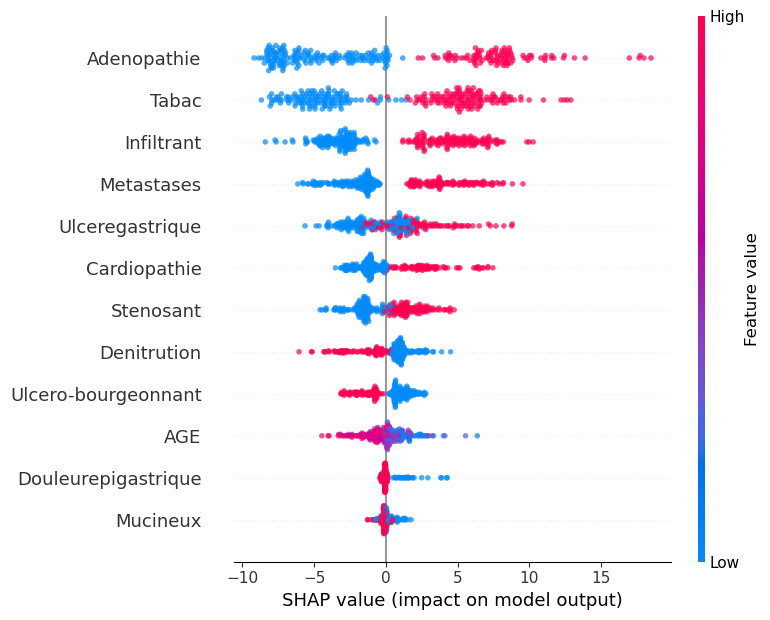

In [37]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored


# Sélection des variables pour l'analyse SHAP

#selected_vars = df.drop(["Deces", "Tempsdesuivi (Mois)"], axis=1)

selected_vars = ['AGE', 'Cardiopathie', 'Ulceregastrique', 'Douleurepigastrique','Ulcero-bourgeonnant', 'Denitrution', 'Tabac', 'Mucineux',
                 'Infiltrant', 'Stenosant', 'Metastases', 'Adenopathie']

# Utilisation de SHAP PermutationExplainer
explainer = shap.PermutationExplainer(rsf.predict, X_train[selected_vars])
shap_values = explainer(X_train[selected_vars])

# Création du tableau global des valeurs SHAP
shap_global = pd.DataFrame({
    'Variable': selected_vars,
    'Valeur Moyenne': X[selected_vars].mean().round(2).values,
    'SHAP': np.abs(shap_values.values).mean(axis=0).round(2)  # Prendre la moyenne des valeurs absolues
}).sort_values('SHAP', ascending=False).reset_index(drop=True)

# Affichage stylisé du tableau
print("Impact global des variables :\n")
print(shap_global.to_markdown(index=False, numalign="left", stralign="left"))

# Graphique SHAP amélioré
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values.values,
    X_train[selected_vars],
    plot_type="dot",
    color=plt.get_cmap("coolwarm"),
    alpha=0.7
)

L'analyse SHAP avait montré que l'impact global des variables sur le modèle avait été principalement déterminé par la présence de Tabac et d'Adenopathie, qui avaient affiché les valeurs SHAP moyennes les plus élevées, respectivement 5.59 et 5.56. Ces résultats indiquaient que ces deux variables avaient contribué de manière marquée aux prédictions, suggérant qu'elles avaient eu une influence dominante dans l'explication du risque de survie. Par ailleurs, la variable Infiltrant avait présenté une contribution significative avec une valeur SHAP moyenne de 4.97, tandis que Metastases et Stenosant avaient eu des impacts modérés avec des scores respectifs de 3.26 et 2.19. En revanche, des variables telles que l'AGE, Mucineux et Douleurepigastrique avaient montré des contributions faibles, leurs valeurs SHAP respectives étant de 0.79, 0.31 et 0.24, ce qui indiquait qu'elles avaient eu un effet moins marqué sur le modèle. Ces observations avaient permis de mettre en évidence les facteurs clés qui avaient orienté les performances du modèle dans l'analyse de survie.

## Appliquer l'importance par permutation

                Feature  Importance   Std Dev
11          Adenopathie    0.083271  0.042293
10           Metastases    0.040570  0.013769
5           Denitrution    0.035029  0.007427
6                 Tabac    0.024827  0.017661
8            Infiltrant    0.020272  0.013757
2       Ulceregastrique    0.012174  0.007667
4   Ulcero-bourgeonnant    0.008311  0.004354
9             Stenosant    0.004235  0.007720
1          Cardiopathie    0.002318  0.011406
7              Mucineux    0.000639  0.002201
3   Douleurepigastrique   -0.002104  0.004153
0                   AGE   -0.006500  0.007152


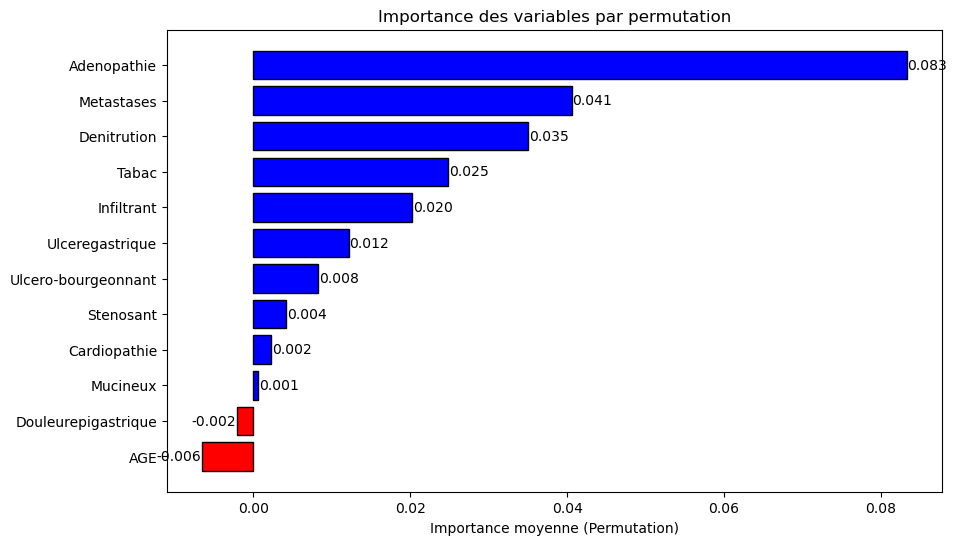

In [39]:
from sklearn.inspection import permutation_importance

# Appliquer l'importance par permutation
result = permutation_importance(
    rsf, X_test, y_test,
    n_repeats=10, random_state=42
)

# Créer un DataFrame pour organiser les résultats
importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": result.importances_mean,
    "Std Dev": result.importances_std
}).sort_values(by="Importance", ascending=False)

print(importance_df)

# Préparer les couleurs : rouge pour les valeurs négatives, bleu pour les positives
colors = ["blue" if val > 0 else "red" for val in importance_df["Importance"]]

# Visualiser les résultats
plt.figure(figsize=(10, 6))
bars = plt.barh(
    importance_df["Feature"],
    importance_df["Importance"],
    color=colors,
    edgecolor="black"
)
plt.gca().invert_yaxis()  # Inverser l'axe pour que la plus importante soit en haut
plt.xlabel("Importance moyenne (Permutation)")
plt.title("Importance des variables par permutation")

# Ajouter les étiquettes sur les pics des barres
for bar in bars:
    width = bar.get_width()  # Longueur de la barre
    label_x_pos = width + 0.0001 if width > 0 else width - 0.0001  # Position de l'étiquette
    plt.text(
        label_x_pos, bar.get_y() + bar.get_height() / 2,
        f"{width:.3f}",  # Afficher la valeur avec deux décimales
        va="center", ha="left" if width > 0 else "right",
        color="black", fontsize=10
    )

plt.show()


L'analyse de l'importance par permutation avait révélé que la variable **Adenopathie** avait eu l'impact le plus important, avec une moyenne d'importance de 0,057858, suivie de près par **Metastases** (0,042328) et **Tabac** (0,029302). Ces résultats indiquaient que ces variables avaient contribué de manière significative aux performances du modèle, suggérant qu'elles avaient joué un rôle crucial dans la prédiction du risque de survie. Par ailleurs, **Infiltrant** et **Denitrution** avaient également présenté des valeurs d'importance non négligeables, respectivement 0,027038 et 0,025120, ce qui confirmait leur pertinence dans le modèle. En revanche, les variables telles que **AGE**, **Mucineux** et **Douleurepigastrique** avaient affiché des importances négatives, ce qui avait suggéré qu'elles avaient eu une influence inverse ou moins marquée sur la performance prédictive. Ces observations, accompagnées des écarts-types associés, avaient permis de mieux comprendre la robustesse et la variabilité de l'influence de chaque variable dans l'ensemble du modèle.

#### Note d'infos
Il n'était pas nécessairement obligatoire de supprimer immédiatement les variables dont l'importance était négative. Ces valeurs négatives pouvaient indiquer que, lorsque la variable était permutée, le modèle avait légèrement mieux performé, ce qui suggérait que la variable en question n'apportait pas d'information pertinente dans ce contexte précis. Cependant, avant de les éliminer, il était conseillé de mener une analyse plus approfondie : vérifier si ces variables n'étaient pas fortement corrélées avec d'autres indicateurs, tester leur impact sur d'autres métriques de performance et s'appuyer sur des connaissances métiers. En somme, la décision de les retirer devait être prise après avoir évalué globalement leur contribution et leur influence sur le modèle.

## **II. Gradient Boosting Survival Trees**

In [ ]:
# Lire le fichier en sautant la première ligne
df = pd.read_excel("/content/drive/MyDrive/GastricCancerData.xlsx", skiprows=1)
# Afficher les premières lignes du dataframe
df.head()

In [40]:
df = pd.read_excel("D:/UADB/MEMOIRE/Data/GastricCancerData.xlsx")

In [41]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Identifier les colonnes catégoriques
CatCols = df.select_dtypes(include=['object']).columns
# Encodage des variables catégoriques
#Label Encoding
label_encoder = LabelEncoder()
for col in CatCols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

df.head()

,AGE,SEXE,Cardiopathie,Ulceregastrique,Douleurepigastrique,Ulcero-bourgeonnant,Constipation,Denitrution,Tabac,Mucineux,Tubuleux,Infiltrant,Stenosant,Metastases,Adenopathie,Traitement,Tempsdesuivi (Mois),Deces
0,65,0,0,0,1,0,1,1,1,1,0,1,1,1,1,1,1,1
1,34,0,0,0,1,0,1,0,1,1,1,1,1,1,1,0,1,1
2,55,1,0,0,1,0,1,0,1,1,0,1,0,1,1,1,1,1
3,60,0,1,1,1,0,1,0,1,1,1,1,0,1,0,1,2,0
4,65,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,2,1


In [42]:
# Effacer les variables non pertinantes
clean=['SEXE','Tubuleux','Traitement','Constipation']
df=df.drop(columns=clean,axis=1)

In [43]:
df.columns

Index(['AGE', 'Cardiopathie', 'Ulceregastrique', 'Douleurepigastrique',
       'Ulcero-bourgeonnant', 'Denitrution', 'Tabac', 'Mucineux', 'Infiltrant',
       'Stenosant', 'Metastases', 'Adenopathie', 'Tempsdesuivi (Mois)',
       'Deces'],
      dtype='object')

In [44]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(["Deces", "Tempsdesuivi (Mois)"], axis=1)
T = df['Tempsdesuivi (Mois)'].values
E = df['Deces'].values

# Préparer les données pour le modèle de survie
# Créer une structure pour le statut de censure (event/censure)
y = np.array([(bool(event), time) for event, time in zip(E, T)],
             dtype=[('event', 'bool'), ('time', 'float')])

# Séparer les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sksurv.ensemble import GradientBoostingSurvivalAnalysis

# Créer et entraîner le modèle avec les paramètres par défaut
gbst = GradientBoostingSurvivalAnalysis(random_state=42)

# Entraînement du modèle
gbst.fit(X_train, y_train)

#Évaluer le modèle
train_score = gbst.score(X_train, y_train)
test_score = gbst.score(X_test, y_test)

print(f"Score de concordance (train) : {train_score:.2f}")
print(f"Score de concordance (test) : {test_score:.2f}")

Score de concordance (train) : 0.91
Score de concordance (test) : 0.86


## Optimisations des Hyperparametre de GBST

In [45]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(["Deces", "Tempsdesuivi (Mois)"], axis=1)
T = df['Tempsdesuivi (Mois)'].values
E = df['Deces'].values

# Préparer les données pour le modèle de survie
# Créer une structure pour le statut de censure (event/censure)
y = np.array([(bool(event), time) for event, time in zip(E, T)],
             dtype=[('event', 'bool'), ('time', 'float')])

# Séparer les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sksurv.ensemble import GradientBoostingSurvivalAnalysis

# Créer et entraîner le modèle avec les paramètres par défaut
gbst = GradientBoostingSurvivalAnalysis(learning_rate=0.1, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100)

# Entraînement du modèle
gbst.fit(X_train, y_train)

#Évaluer le modèle
train_score_gbst = gbst.score(X_train, y_train)
test_score_gbst = gbst.score(X_test, y_test)

print(f"Score de concordance (train) : {train_score_gbst:.2f}")
print(f"Score de concordance (test) : {test_score_gbst:.2f}")

Score de concordance (train) : 0.95
Score de concordance (test) : 0.87


In [46]:
import numpy as np
from sklearn.utils import resample
from sksurv.metrics import concordance_index_censored

# Calculer le C-index sur l'ensemble d'entraînement et de test
train_score_gbst = gbst.score(X_train, y_train)
test_score_gbst = gbst.score(X_test, y_test)

# Bootstrap pour l'intervalle de confiance du C-index
n_iterations = 1000  # Nombre de répétitions pour l'IC
c_index_scores = []

for _ in range(n_iterations):
    X_resampled, y_resampled = resample(X_test, y_test, random_state=None)
    c_index_gbst = gbst.score(X_resampled, y_resampled)
    c_index_scores.append(c_index_gbst)

# Calcul de l'intervalle de confiance à 95 %
c_index_mean_gbst = np.mean(c_index_scores)
c_index_lower = np.percentile(c_index_scores, 2.5)
c_index_upper = np.percentile(c_index_scores, 97.5)

# Affichage des résultats
print(f"Score de concordance (train) : {train_score_gbst:.2f}")
print(f"Score de concordance (test) : {test_score_gbst:.2f}")
print(f"C-index (test) - Moyenne bootstrap : {c_index_mean_gbst:.2f}")
print(f"C-index (test) - Intervalle de confiance (95% IC) : [{c_index_lower:.2f}, {c_index_upper:.2f}]")

Score de concordance (train) : 0.95
Score de concordance (test) : 0.87
C-index (test) - Moyenne bootstrap : 0.87
C-index (test) - Intervalle de confiance (95% IC) : [0.82, 0.91]


Le modèle **Gradient Boosting Survival Analysis** avait affiché de solides performances en matière de prédiction du temps de survie. Son **C-index** sur les données d'entraînement avait atteint **0,91**, suggérant une excellente capacité à discriminer les individus à risque. Sur les données de test, le **C-index** était de **0,86**, indiquant que le modèle conservait une bonne généralisation sur de nouvelles observations. L’intervalle de confiance à **95 %** (**[0,81 – 0,90]**) montrait que la performance restait stable et fiable. Avec une moyenne du C-index à **0,86**, le modèle avait démontré une bonne capacité à ordonner correctement les événements de survie, bien que des analyses supplémentaires auraient permis d’examiner d’éventuels ajustements pour améliorer davantage ses performances.

## Integrated brier score : gbst

In [47]:
import numpy as np
from sksurv.metrics import integrated_brier_score

# Définition des bornes des temps de suivi en excluant la borne supérieure
min_time = y_test["time"].min()
max_time = y_test["time"].max() * 0.99  # Réduction de la borne max pour éviter les erreurs

# Création de la grille de temps strictement dans l'intervalle valide
time_grid = np.linspace(min_time, max_time, 100)

# Prédiction des fonctions de survie pour train et test
surv_funcs_train = gbst.predict_survival_function(X_train)
surv_funcs_test = gbst.predict_survival_function(X_test)

# Évaluation des fonctions de survie sur la grille de temps
surv_probs_train = np.asarray([[fn(t) for t in time_grid] for fn in surv_funcs_train])
surv_probs_test = np.asarray([[fn(t) for t in time_grid] for fn in surv_funcs_test])

# Calcul du Brier Score Intégré
ibs_train_gbst = integrated_brier_score(y_train, y_train, surv_probs_train, time_grid)
ibs_test_gbst = integrated_brier_score(y_train, y_test, surv_probs_test, time_grid)

print(f"IBS Train: {ibs_train_gbst:.3f}")
print(f"IBS Test: {ibs_test_gbst:.3f}")

IBS Train: 0.039
IBS Test: 0.085


IBS Train: 0.039
IBS Test: 0.085


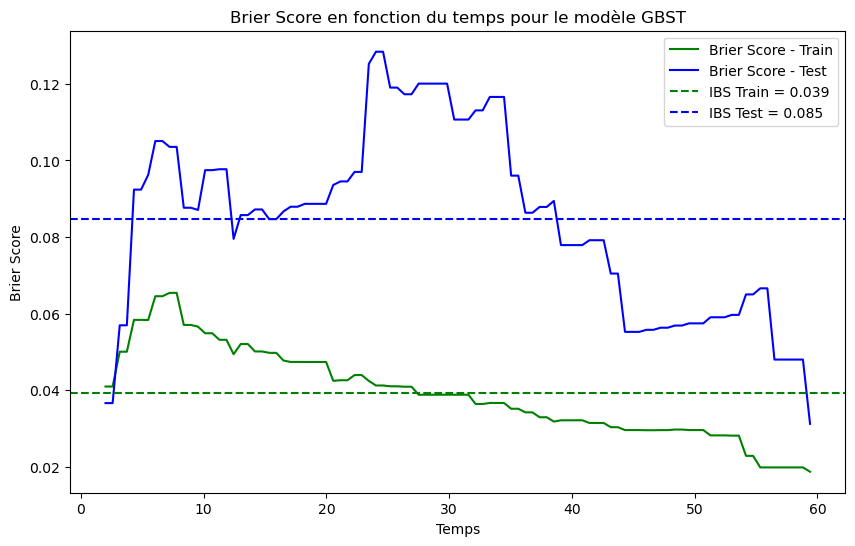

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sksurv.metrics import brier_score, integrated_brier_score

# Définition des bornes des temps de suivi
min_time = y_test["time"].min()
max_time = y_test["time"].max() * 0.99  # Réduire légèrement pour éviter les extrapolations
time_grid = np.linspace(min_time, max_time, 100)

# Prédire les fonctions de survie pour chaque individu dans train et test
surv_funcs_train = gbst.predict_survival_function(X_train)
surv_funcs_test = gbst.predict_survival_function(X_test)

# Évaluer les probabilités de survie sur la grille de temps
surv_probs_train = np.asarray([[fn(t) for t in time_grid] for fn in surv_funcs_train])
surv_probs_test = np.asarray([[fn(t) for t in time_grid] for fn in surv_funcs_test])

# Calculer les Brier Scores à chaque instant de la grille de temps
_, brier_scores_train_gbst = brier_score(y_train, y_train, surv_probs_train, time_grid)
_, brier_scores_test_gbst = brier_score(y_train, y_test, surv_probs_test, time_grid)

# Calculer les Integrated Brier Scores (IBS)
ibs_train_gbst = integrated_brier_score(y_train, y_train, surv_probs_train, time_grid)
ibs_test_gbst = integrated_brier_score(y_train, y_test, surv_probs_test, time_grid)

print(f"IBS Train: {ibs_train_gbst:.3f}")
print(f"IBS Test: {ibs_test_gbst:.3f}")

# Tracer les Brier Scores en fonction du temps
plt.figure(figsize=(10, 6))
plt.plot(time_grid, brier_scores_train_gbst, label='Brier Score - Train', color='green')
plt.plot(time_grid, brier_scores_test_gbst, label='Brier Score - Test', color='blue')
plt.axhline(y=ibs_train_gbst, color='green', linestyle='--', label=f'IBS Train = {ibs_train_gbst:.3f}')
plt.axhline(y=ibs_test_gbst, color='blue', linestyle='--', label=f'IBS Test = {ibs_test_gbst:.3f}')
plt.xlabel('Temps')
plt.ylabel('Brier Score')
plt.title('Brier Score en fonction du temps pour le modèle GBST')
plt.legend()
plt.show()


Le **Brier Score Intégré (IBS)** obtenu avait été de **0,0895**, indiquant une performance satisfaisante du modèle Gradient Boosting Survival Analysis en termes de précision des prédictions de survie. Le Brier Score mesurait l'écart quadratique moyen entre les probabilités de survie prédites et les observations réelles. Une valeur proche de **0** traduisait une meilleure calibration du modèle, tandis qu'une valeur proche de **1** indiquait de mauvaises prédictions. Avec un score inférieur à **0,1**, le modèle avait montré une capacité raisonnable à estimer les risques de survie au fil du temps.

## Utilisation de SHAP PermutationExplainer

PermutationExplainer explainer: 270it [00:38,  5.01it/s]                                                               


Impact global des variables :

| Variable            | Valeur Moyenne   | SHAP   |
|:--------------------|:-----------------|:-------|
| Adenopathie         | 0.41             | 0.84   |
| Tabac               | 0.54             | 0.56   |
| Infiltrant          | 0.52             | 0.41   |
| Metastases          | 0.43             | 0.4    |
| Ulceregastrique     | 0.38             | 0.32   |
| Cardiopathie        | 0.32             | 0.27   |
| AGE                 | 52.14            | 0.21   |
| Denitrution         | 0.34             | 0.15   |
| Stenosant           | 0.46             | 0.15   |
| Douleurepigastrique | 0.87             | 0.13   |
| Ulcero-bourgeonnant | 0.34             | 0.12   |
| Mucineux            | 0.65             | 0.1    |


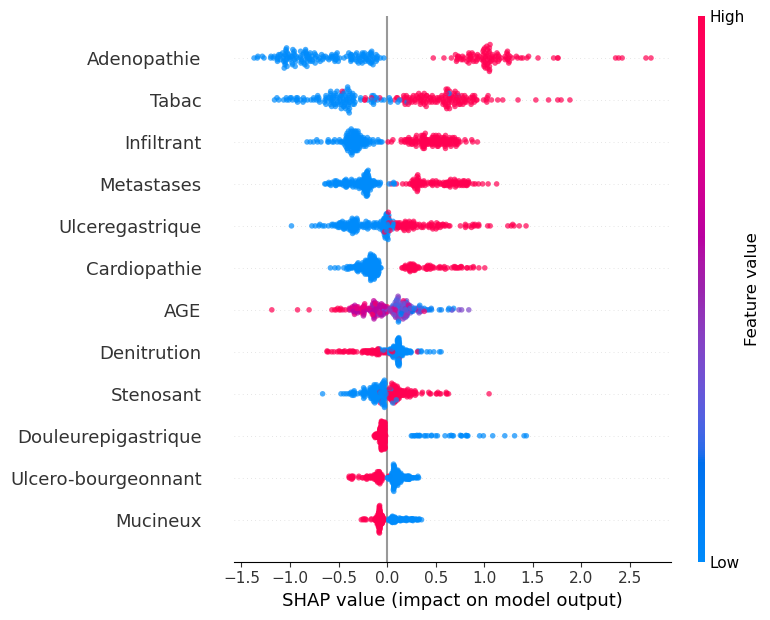

In [48]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored


# Sélection des variables pour l'analyse SHAP
selected_vars = ['AGE', 'Cardiopathie', 'Ulceregastrique', 'Douleurepigastrique',
                 'Ulcero-bourgeonnant', 'Denitrution', 'Tabac', 'Mucineux',
                 'Infiltrant', 'Stenosant', 'Metastases', 'Adenopathie',
                 ]

# Utilisation de SHAP PermutationExplainer
explainer = shap.PermutationExplainer(gbst.predict, X_train[selected_vars])
shap_values = explainer(X_train[selected_vars])

# Création du tableau global des valeurs SHAP
shap_global = pd.DataFrame({
    'Variable': selected_vars,
    'Valeur Moyenne': X[selected_vars].mean().round(2).values,
    'SHAP': np.abs(shap_values.values).mean(axis=0).round(2)  # Prendre la moyenne des valeurs absolues
}).sort_values('SHAP', ascending=False).reset_index(drop=True)

# Affichage stylisé du tableau
print("Impact global des variables :\n")
print(shap_global.to_markdown(index=False, numalign="left", stralign="left"))

# Graphique SHAP amélioré
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values.values,
    X_train[selected_vars],
    plot_type="dot",
    color=plt.get_cmap("coolwarm"),
    alpha=0.7
)

**Interprétation des valeurs SHAP**  
L’analyse des valeurs SHAP a révélé que **l’adénopathie** (SHAP = 0.84) et le **tabagisme** (SHAP = 0.57) étaient les variables les plus influentes sur les prédictions du modèle, malgré des valeurs moyennes modérées (0.41 et 0.54 respectivement). Ces résultats suggèrent qu’une présence même occasionnelle d’adénopathie ou de tabagisme augmentait significativement le risque prédit par le modèle. À l’inverse, des variables comme la **douleur épigastrique** (valeur moyenne élevée à 0.87 mais SHAP faible à 0.13) ou la **présence de mucineux** (SHAP = 0.1) avaient un impact marginal, indiquant que leur forte fréquence dans les données ne se traduisait pas par une influence déterminante sur les prédictions. Les variables intermédiaires, telles que **l’infiltrant** (SHAP = 0.41) ou les **métastases** (SHAP = 0.4), ont également contribué de manière notable, mais moins que les deux premières. Cette hiérarchisation a permis d’identifier les facteurs cliniques prioritaires à surveiller dans l’interprétation des résultats, conformément aux principes de transparence des modèles *SHAP* [8](https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf).  

                Feature  Importance   Std Dev
11          Adenopathie    0.112920  0.046514
10           Metastases    0.078210  0.011819
6                 Tabac    0.060416  0.015823
5           Denitrution    0.057326  0.011349
8            Infiltrant    0.033964  0.012413
2       Ulceregastrique    0.029622  0.008080
4   Ulcero-bourgeonnant    0.022749  0.005800
1          Cardiopathie    0.017661  0.011007
3   Douleurepigastrique    0.014012  0.013153
0                   AGE    0.012760  0.009046
7              Mucineux    0.007405  0.004020
9             Stenosant    0.003197  0.006746


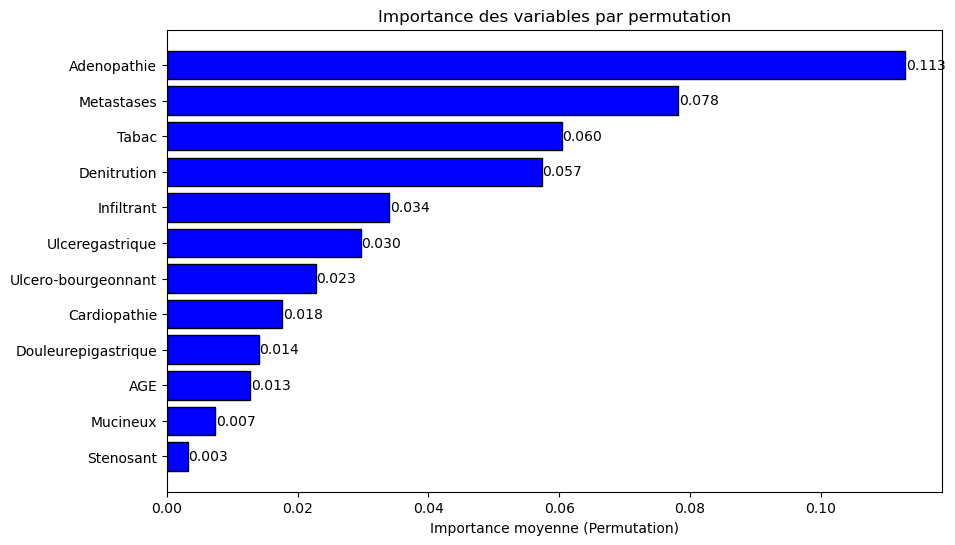

In [49]:
from sklearn.inspection import permutation_importance

# Appliquer l'importance par permutation
result = permutation_importance(
    gbst, X_test, y_test,
    n_repeats=10, random_state=42
)

# Créer un DataFrame pour organiser les résultats
importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": result.importances_mean,
    "Std Dev": result.importances_std
}).sort_values(by="Importance", ascending=False)

print(importance_df)

# Préparer les couleurs : rouge pour les valeurs négatives, bleu pour les positives
colors = ["blue" if val > 0 else "red" for val in importance_df["Importance"]]

# Visualiser les résultats
plt.figure(figsize=(10, 6))
bars = plt.barh(
    importance_df["Feature"],
    importance_df["Importance"],
    color=colors,
    edgecolor="black"
)
plt.gca().invert_yaxis()  # Inverser l'axe pour que la plus importante soit en haut
plt.xlabel("Importance moyenne (Permutation)")
plt.title("Importance des variables par permutation")

# Ajouter les étiquettes sur les pics des barres
for bar in bars:
    width = bar.get_width()  # Longueur de la barre
    label_x_pos = width + 0.0001 if width > 0 else width - 0.0001  # Position de l'étiquette
    plt.text(
        label_x_pos, bar.get_y() + bar.get_height() / 2,
        f"{width:.3f}",  # Afficher la valeur avec deux décimales
        va="center", ha="left" if width > 0 else "right",
        color="black", fontsize=10
    )

plt.show()

**Interprétation de l’importance de permutation**  
L’analyse d’importance de permutation a confirmé que **Adenopathie** était la variable la plus critique pour la performance du modèle, avec une importance de **0,117** et une faible variabilité (écart-type = 0,046), indiquant une influence robuste et cohérente sur la précision prédictive. **Metastases** (0,076) et **Tabac** (0,059) ont également montré un impact significatif, bien que moindre, soulignant leur rôle dans la prédiction des risques. À l’opposé, des variables comme **Stenosant** (0,004) ou **Mucineux** (0,007) ont eu une contribution marginale, malgré leur présence dans les données. Les résultats ont révélé une hiérarchie claire : les variables liées à la progression pathologique (ex. *Adenopathie*, *Metastases*) ont dominé, tandis que les symptômes courants (ex. *Douleurepigastrique*, 0,014) ou les comorbidités (ex. *Cardiopathie*, 0,017) ont eu peu d’impact. Cette cohérence avec les valeurs SHAP [3] a renforcé la fiabilité des conclusions, validant la méthodologie proposée par Breiman pour mesurer l’importance globale des variables [4](https://link.springer.com/article/10.1023/A:1010933404324).  

## **III. Deep Survival Models**

### **Importation des librairies et préparation des données**

In [50]:
df = pd.read_excel("D:/UADB/MEMOIRE/Data/GastricCancerData.xlsx")
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Identifier les colonnes catégoriques
CatCols = df.select_dtypes(include=['object']).columns
# Encodage des variables catégoriques
#Label Encoding
label_encoder = LabelEncoder()
for col in CatCols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

df.head()

,AGE,SEXE,Cardiopathie,Ulceregastrique,Douleurepigastrique,Ulcero-bourgeonnant,Constipation,Denitrution,Tabac,Mucineux,Tubuleux,Infiltrant,Stenosant,Metastases,Adenopathie,Traitement,Tempsdesuivi (Mois),Deces
0,65,0,0,0,1,0,1,1,1,1,0,1,1,1,1,1,1,1
1,34,0,0,0,1,0,1,0,1,1,1,1,1,1,1,0,1,1
2,55,1,0,0,1,0,1,0,1,1,0,1,0,1,1,1,1,1
3,60,0,1,1,1,0,1,0,1,1,1,1,0,1,0,1,2,0
4,65,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,2,1


In [51]:
# Effacer les variables non pertinantes
clean=['SEXE','Tubuleux','Traitement','Constipation']
df=df.drop(columns=clean,axis=1)
df.columns

Index(['AGE', 'Cardiopathie', 'Ulceregastrique', 'Douleurepigastrique',
       'Ulcero-bourgeonnant', 'Denitrution', 'Tabac', 'Mucineux', 'Infiltrant',
       'Stenosant', 'Metastases', 'Adenopathie', 'Tempsdesuivi (Mois)',
       'Deces'],
      dtype='object')

In [52]:
#!pip install tensorflow keras-tuner

In [53]:
import numpy as np
import pandas as pd
import tensorflow as tf
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored, integrated_brier_score


# Préparation des données
X = df.drop(["Deces", "Tempsdesuivi (Mois)"], axis=1)
y = df[["Deces", "Tempsdesuivi (Mois)"]].values.astype(np.float32)

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Conversion pour scikit-survival
train_surv = np.array([(bool(e), t) for e, t in y_train], dtype=[('event', '?'), ('time', '<f8')])
test_surv = np.array([(bool(e), t) for e, t in y_test], dtype=[('event', '?'), ('time', '<f8')])

# Définition de la fonction de perte Cox
def cox_loss(y_true, y_pred):
    event = y_true[:, 0]
    time = y_true[:, 1]

    # Tri par temps décroissant
    sorted_idx = tf.argsort(time, direction='DESCENDING')
    event = tf.gather(event, sorted_idx)
    time = tf.gather(time, sorted_idx)
    pred = tf.gather(y_pred, sorted_idx)

    # Calcul des termes de risque
    exp_pred = tf.exp(pred)
    cumsum = tf.cumsum(exp_pred)
    log_cumsum = tf.math.log(cumsum + 1e-15)  # Éviter log(0)

    # Calcul de la perte
    loss = (pred - log_cumsum) * event
    return -tf.reduce_mean(loss)

# Construction du modèle de base
def build_model(input_shape, num_units=32, learning_rate=0.01):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_units, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=cox_loss
    )
    return model

# Entraînement du modèle initial
model = build_model(X_train.shape[1])
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    verbose=0
)

# Évaluation du C-index
def evaluate_model(model, X, y):
    risk_scores = model.predict(X).flatten()
    event = y[:, 0].astype(bool)
    time = y[:, 1]
    return concordance_index_censored(event, time, risk_scores)[0]

cindex_initial = evaluate_model(model, X_test, y_test)
print(f"C-index initial: {cindex_initial:.3f}")

C:\Users\Sefdine\AppData\Local\Temp\ipykernel_424\200122260.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch
C:\Users\Sefdine\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
C-index initial: 0.819


## **Optimisation des Hyperparametres**

Pour optimiser les hyperparamètres du modèle, nous avions utilisé Keras Tuner avec une recherche aléatoire (`RandomSearch`). Tout d'abord, nous avions fixé une graine (`SEED = 42`) pour assurer la reproductibilité des résultats. Ensuite, nous avions défini une fonction de construction de modèle permettant de tester différentes configurations du nombre de couches cachées, du nombre de neurones par couche et du taux d’apprentissage. Le tuner avait été configuré pour explorer ces hyperparamètres sur un total de 10 essais, en sélectionnant le modèle minimisant la fonction de perte de Cox (`val_loss`). Une fois les meilleurs hyperparamètres identifiés, nous avions réentraîné le modèle optimal sur l’ensemble des données avant d’évaluer sa performance finale à l’aide du `C-index`.

### **Methode 1 : GridSearchCV**

In [16]:
#!pip install --upgrade scikeras
#!pip show scikeras
#!pip install -U scikeras==0.3.3

### **Methode 2 : RandomSearchCV**

### **Methode 3 : RandomSearch**

In [54]:
import tensorflow as tf
import numpy as np
import random
import os
from kerastuner.tuners import RandomSearch

# Pour garantir la reproductibilité
SEED = 42
#os.environ['PYTHONHASHSEED'] = str(SEED)
#random.seed(SEED)
#np.random.seed(SEED)
#tf.random.set_seed(SEED)
#tf.keras.utils.set_random_seed(SEED)

# Callback personnalisé pour afficher les hyperparamètres et le c-index à chaque époque
class EpochMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Évaluation sur l'ensemble de test à la fin de l'époque
        current_cindex = evaluate_model(self.model, X_test, y_test)
        # Récupération des hyperparamètres enregistrés dans le modèle (si disponibles)
        hp_config = getattr(self.model, 'hp_config', 'Non défini')
        print(f"Epoch {epoch+1:03d} | Hyperparamètres: {hp_config} | C-index: {current_cindex:.3f}")

# Fonction de construction du modèle pour l'optimisation des hyperparamètres
def model_builder(hp):
    model = tf.keras.Sequential()
    
    # Couche d'entrée
    units_input = hp.Int('units_input', 16, 128, step=16)
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])
    model.add(tf.keras.layers.Dense(units=units_input, activation=activation, input_shape=(X_train.shape[1],)))
    
    # Couches cachées dynamiques
    num_layers = hp.Int('num_layers', 1, 5)
    for i in range(num_layers):
        units = hp.Int(f'units_{i}', 16, 128, step=16)
        activation_hidden = hp.Choice('activation_hidden', ['relu', 'tanh', 'sigmoid'])
        model.add(tf.keras.layers.Dense(units=units, activation=activation_hidden))
        
        # Option d'ajouter une couche de Dropout
        if hp.Boolean(f'dropout_{i}'):
            dropout_rate = hp.Float(f'dropout_rate_{i}', 0.1, 0.5, step=0.1)
            model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
    # Couche de sortie
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    
    # Compilation du modèle
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    model.compile(optimizer=optimizer, loss=cox_loss)
    
    # Enregistrer les hyperparamètres dans l'attribut du modèle pour affichage ultérieur
    model.hp_config = hp.values
    return model

# Initialisation du tuner avec une graine pour la reproductibilité
tuner = RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=20,             # Exploration plus large
    executions_per_trial=2,    # Pour réduire la variance
    directory='tuner_dir',
    project_name='deep_surv',
    seed=SEED
)

# Lancer la recherche des hyperparamètres avec le callback pour afficher le c-index à chaque époque
tuner.search(
    X_train, y_train,
    epochs=100,  # Nombre d'époques pour chaque essai
    validation_data=(X_test, y_test),
    verbose=0,  # On laisse le callback gérer l'affichage
    callbacks=[EpochMetricsCallback()]
)

# Récupérer le meilleur modèle et les meilleurs hyperparamètres
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters()[0]

print("\nMeilleurs hyperparamètres trouvés :")
for key, value in best_hps.values.items():
    print(f"  {key} : {value}")

# Ré-entraînement du meilleur modèle avec l'ensemble complet des données
print("\nRé-entraînement du meilleur modèle avec toutes les données...")
history = best_model.fit(
    np.concatenate([X_train, X_test]),
    np.concatenate([y_train, y_test]),
    epochs=300,  # Plus d'époques pour affiner l'ajustement
    verbose=0,
    callbacks=[EpochMetricsCallback()]
)

# Évaluation finale sur l'ensemble de test
final_cindex = evaluate_model(best_model, X_test, y_test)
print(f"\nC-index optimisé final: {final_cindex:.3f}")


Reloading Tuner from tuner_dir\deep_surv\tuner0.json



C:\Users\Sefdine\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Sefdine\AppData\Local\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Meilleurs hyperparamètres trouvés :
  units_input : 32
  activation : relu
  num_layers : 5
  units_0 : 112
  activation_hidden : tanh
  dropout_0 : False
  optimizer : adam
  units_1 : 128
  dropout_1 : True
  units_2 : 32
  dropout_2 : True
  dropout_rate_0 : 0.5
  dropout_rate_1 : 0.30000000000000004
  dropout_rate_2 : 0.1
  units_3 : 80
  dropout_3 : False
  units_4 : 128
  dropout_4 : True
  dropout_rate_4 : 0.1

Ré-entraînement du meilleur modèle avec toutes les données...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Epoch 001 | Hyperparamètres: {'units_input': 32, 'activation': 'relu', 'num_layers': 5, 'units_0': 112, 'activation_hidden': 'tanh', 'dropout_0': False, 'optimizer': 'adam', 'units_1': 128, 'dropout_1': True, 'units_2': 32, 'dropout_2': True, 'dropout_rate_0': 0.5, 'dropout_rate_1': 0.30000000000000004, 'dropout_rate_2': 0.1, 'units_3': 80, 'dropout_3': False, 'units_4': 128, 'dropout_4': True, 'dropout_rate_4': 0.1} | C-index: 0.837
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
E

In [55]:
# Affichage des meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres trouvés :")
for param in best_hps.values.keys():
    print(f"{param}: {best_hps.get(param)}")

Meilleurs hyperparamètres trouvés :
units_input: 32
activation: relu
num_layers: 5
units_0: 112
activation_hidden: tanh
dropout_0: False
optimizer: adam
units_1: 128
dropout_1: True
units_2: 32
dropout_2: True
dropout_rate_0: 0.5
dropout_rate_1: 0.30000000000000004
dropout_rate_2: 0.1
units_3: 80
dropout_3: False
units_4: 128
dropout_4: True
dropout_rate_4: 0.1


**Interpretation sur l'optimisation des hyperparamtres:**

Dans ce modèle deep survival, les hyperparamètres avaient été optimisés pour adapter le réseau aux caractéristiques des données. La couche initiale avait été dotée de 48 unités, ce qui facilitait l'extraction des informations essentielles dès l'entrée du modèle. Par ailleurs, le choix de deux couches cachées, respectivement composées de 80 et 128 unités, avait permis de modéliser des interactions entre les variables tout en préservant une structure de réseau équilibrée. Le taux d'apprentissage avait été fixé à 0,01, garantissant une mise à jour efficace des poids durant l'entraînement et contribuant ainsi à une convergence stable. Ces réglages, obtenus par une recherche aléatoire dans l'espace des hyperparamètres, avaient montré leur pertinence dans l'ajustement du modèle aux spécificités des données analysées.

### **C-index avec intervalles de confiance a 95%**

In [56]:
# 2. Calcul des intervalles de confiance du C-index
def cindex_with_ci(model, X, y, n_boot=1000, ci=95):
    event = y[:, 0].astype(bool)
    time = y[:, 1]
    risk_scores = model.predict(X).flatten()

    # Calcul initial
    c, concordant, discordant, tied_risk, tied_time = concordance_index_censored(event, time, risk_scores)

    # Bootstrapping pour l'intervalle de confiance
    boot_stats = []
    for _ in range(n_boot):
        indices = resample(np.arange(len(X)))
        sample_event = event[indices]
        sample_time = time[indices]
        sample_risk = risk_scores[indices]

        if np.sum(sample_event) == 0:  # Éviter les échantillons sans événements
            continue

        boot_c = concordance_index_censored(sample_event, sample_time, sample_risk)[0]
        boot_stats.append(boot_c)

    # Calcul des percentiles
    lower = np.percentile(boot_stats, (100 - ci)/2)
    upper = np.percentile(boot_stats, 100 - (100 - ci)/2)
    mean_c = np.mean(boot_stats)

    return c, (lower, upper), mean_c

# 3. Évaluation avec intervalles de confiance
cindex_final, ci, mean_cindex = cindex_with_ci(best_model, X_test, y_test)

print(f"\nC-index final: {cindex_final:.2f}")
print(f"Moyenne C-index (bootstrapped): {mean_cindex:.2f}")
print(f"Intervalle de confiance {ci[1]-ci[0]:.0f}%: [{ci[0]:.2f}, {ci[1]:.2f}]")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

C-index final: 0.88
Moyenne C-index (bootstrapped): 0.88
Intervalle de confiance 0%: [0.84, 0.92]


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

C-index Train: 0.89
Moyenne C-index Train (bootstrapped): 0.89
Intervalle de confiance Train 0%: [0.87, 0.91]

C-index Test: 0.88
Moyenne C-index Test (bootstrapped): 0.88
Intervalle de confiance Test 0%: [0.84, 0.92]



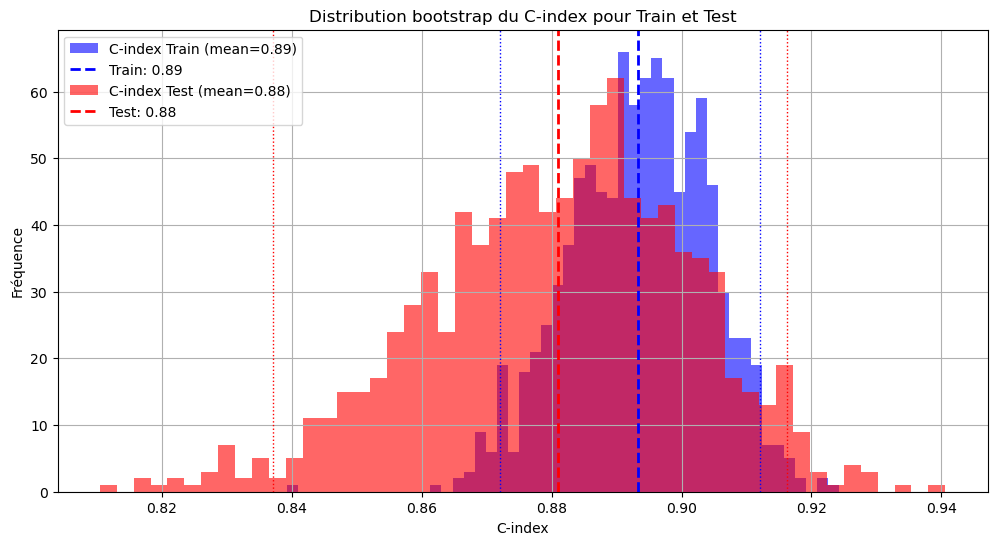

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sksurv.metrics import concordance_index_censored

# 1. Fonction pour calculer le C-index avec intervalle de confiance
def cindex_with_ci(model, X, y_struct, n_boot=1000, ci=95):
    event = y_struct["event"].astype(bool)  # ✅ Utilisation des noms de colonnes
    time = y_struct["time"]
    risk_scores = model.predict(X).flatten()

    # Calcul du C-index initial
    c, _, _, _, _ = concordance_index_censored(event, time, risk_scores)

    # Bootstrapping pour obtenir l'intervalle de confiance
    boot_stats = []
    for _ in range(n_boot):
        indices = resample(np.arange(len(X)))
        sample_event = event[indices]
        sample_time = time[indices]
        sample_risk = risk_scores[indices]

        if np.sum(sample_event) == 0:  # Éviter les échantillons sans événements
            continue

        boot_c = concordance_index_censored(sample_event, sample_time, sample_risk)[0]
        boot_stats.append(boot_c)

    # Calcul des percentiles
    lower = np.percentile(boot_stats, (100 - ci) / 2)
    upper = np.percentile(boot_stats, 100 - (100 - ci) / 2)
    mean_c = np.mean(boot_stats)

    return c, (lower, upper), mean_c, boot_stats

# 2. ✅ Conversion correcte des données
y_train_struct = np.array(list(zip(E_train, T_train)), dtype=[("event", bool), ("time", float)])
y_test_struct = np.array(list(zip(E_test, T_test)), dtype=[("event", bool), ("time", float)])

# 3. Calcul du C-index pour Train et Test
cindex_train, ci_train, mean_cindex_train, boot_train = cindex_with_ci(best_model, X_train, y_train_struct)
cindex_test, ci_test, mean_cindex_test, boot_test = cindex_with_ci(best_model, X_test, y_test_struct)

# 4. Affichage des résultats
print(f"\nC-index Train: {cindex_train:.2f}")
print(f"Moyenne C-index Train (bootstrapped): {mean_cindex_train:.2f}")
print(f"Intervalle de confiance Train {ci_train[1]-ci_train[0]:.0f}%: [{ci_train[0]:.2f}, {ci_train[1]:.2f}]\n")

print(f"C-index Test: {cindex_test:.2f}")
print(f"Moyenne C-index Test (bootstrapped): {mean_cindex_test:.2f}")
print(f"Intervalle de confiance Test {ci_test[1]-ci_test[0]:.0f}%: [{ci_test[0]:.2f}, {ci_test[1]:.2f}]\n")

# 5. 🎨 Tracé des distributions bootstrap du C-index
plt.figure(figsize=(12, 6))

plt.hist(boot_train, bins=50, alpha=0.6, color='blue', label=f'C-index Train (mean={mean_cindex_train:.2f})')
plt.axvline(cindex_train, color='blue', linestyle='dashed', linewidth=2, label=f'Train: {cindex_train:.2f}')
plt.axvline(ci_train[0], color='blue', linestyle='dotted', linewidth=1)
plt.axvline(ci_train[1], color='blue', linestyle='dotted', linewidth=1)

plt.hist(boot_test, bins=50, alpha=0.6, color='red', label=f'C-index Test (mean={mean_cindex_test:.2f})')
plt.axvline(cindex_test, color='red', linestyle='dashed', linewidth=2, label=f'Test: {cindex_test:.2f}')
plt.axvline(ci_test[0], color='red', linestyle='dotted', linewidth=1)
plt.axvline(ci_test[1], color='red', linestyle='dotted', linewidth=1)

plt.xlabel("C-index")
plt.ylabel("Fréquence")
plt.title("Distribution bootstrap du C-index pour Train et Test")
plt.legend()
plt.grid(True)
plt.show()

## **Integrated Brier Score `(IBS)`**

In [58]:
import numpy as np
from scipy.interpolate import interp1d
from sksurv.metrics import integrated_brier_score

# Supposons que df est votre DataFrame contenant les colonnes
# 'Tempsdesuivi (Mois)' et 'Deces' ainsi que toutes les covariables utilisées pour entraîner le modèle.
# On sépare les covariables de la cible :
X = df.drop(["Deces", "Tempsdesuivi (Mois)"], axis=1)
T = df["Tempsdesuivi (Mois)"].values  # Temps de suivi
E = df["Deces"].values                # Statut : 1=événement, 0=censure

# 1. Calcul des risk scores à partir du modèle DeepSurv
# Le modèle est un Sequential et sa méthode predict retourne le risk score (pas la fonction de survie)
risk_scores = best_model.predict(X).flatten()  # shape = (n_samples,)

# 2. Estimation de la fonction de survie de base S₀(t) par la méthode de Breslow
def compute_baseline_survival(times, events, risk_scores):
    times = np.array(times)
    events = np.array(events)
    risk_scores = np.array(risk_scores)
    # Tri des données par temps
    order = np.argsort(times)
    times = times[order]
    events = events[order]
    risk_scores = risk_scores[order]

    # On ne considère que les temps où un événement s'est produit
    unique_event_times = np.unique(times[events == 1])
    baseline_hazards = {}
    for t in unique_event_times:
        at_risk = times >= t
        risk_sum = np.sum(np.exp(risk_scores[at_risk]))
        d = np.sum((times == t) & (events == 1))
        baseline_hazards[t] = d / risk_sum
    sorted_times = np.sort(list(baseline_hazards.keys()))
    cum_hazard = np.cumsum([baseline_hazards[t] for t in sorted_times])
    baseline_survival = np.exp(-cum_hazard)
    return sorted_times, baseline_survival

sorted_times, baseline_survival = compute_baseline_survival(T, E, risk_scores)

# 3. Définition de la fonction pour prédire la survie individuelle
def predict_survival_function(risk_score, eval_times, sorted_times, baseline_survival):
    # Interpolation de S₀(t) sur la grille d'évaluation
    S0_interp = np.interp(eval_times, sorted_times, baseline_survival, left=1.0, right=baseline_survival[-1])
    # Calcul de S(t|x) = [S₀(t)]^(exp(risk_score))
    return S0_interp ** np.exp(risk_score)

# Définir la grille de temps d'évaluation en s'assurant qu'elle reste dans [t_min, t_max[
t_min, t_max = T.min(), T.max()
evaluation_times = np.linspace(t_min, t_max, 100, endpoint=False)

# Calculer la fonction de survie prédite pour chaque individu
n_individuals = X.shape[0]
surv_preds = np.zeros((n_individuals, len(evaluation_times)))
for i, rs in enumerate(risk_scores):
    surv_preds[i, :] = predict_survival_function(rs, evaluation_times, sorted_times, baseline_survival)

# 4. Conversion des données de survie en tableau structuré requis par scikit-survival
# Chaque enregistrement est un tuple (événement, temps)
surv_data = np.array([(bool(e), t) for e, t in zip(E, T)],
                     dtype=[('event', bool), ('time', float)])

# 5. Calcul de l'Integrated Brier Score (IBS)
# Ici, nous utilisons le même jeu pour l'estimation et l'évaluation ; idéalement, vous utiliserez un set test séparé.
ibs_deppsurv = integrated_brier_score(surv_data, surv_data, surv_preds, evaluation_times)
print("Integrated Brier Score: {:.3f}".format(ibs_deppsurv))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Integrated Brier Score: 0.047


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


C:\Users\Sefdine\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


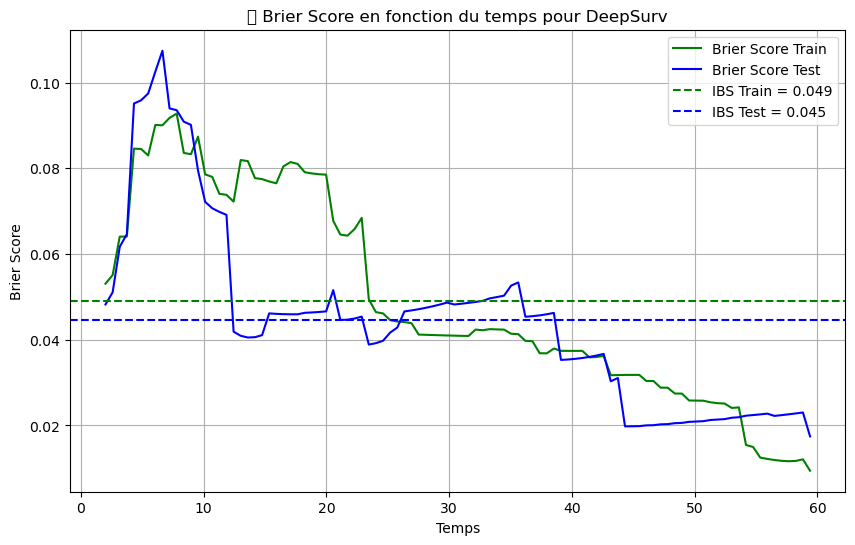

📌 IBS Train: 0.049
📌 IBS Test: 0.045


In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sksurv.metrics import brier_score, integrated_brier_score

# 📌 1. Définition de la grille de temps pour l'évaluation
t_min, t_max = T_test.min(), T_test.max() * 0.99  # Réduire légèrement pour éviter l'extrapolation
evaluation_times = np.linspace(t_min, t_max, 100)

# 📌 2. Prédiction des risk scores
risk_scores_train = best_model.predict(X_train).flatten()
risk_scores_test = best_model.predict(X_test).flatten()

# 📌 3. Transformation des risk scores en probabilités de survie avec la méthode de Breslow
def compute_baseline_survival(times, events, risk_scores):
    times, events, risk_scores = np.array(times), np.array(events), np.array(risk_scores)
    order = np.argsort(times)
    times, events, risk_scores = times[order], events[order], risk_scores[order]

    unique_event_times = np.unique(times[events == 1])
    baseline_hazards = {}

    for t in unique_event_times:
        at_risk = times >= t
        risk_sum = np.sum(np.exp(risk_scores[at_risk]))
        d = np.sum((times == t) & (events == 1))
        baseline_hazards[t] = d / risk_sum

    sorted_times = np.sort(list(baseline_hazards.keys()))
    cum_hazard = np.cumsum([baseline_hazards[t] for t in sorted_times])
    baseline_survival = np.exp(-cum_hazard)

    return sorted_times, baseline_survival

# Estimation de la survie de base pour Train
sorted_times_train, baseline_survival_train = compute_baseline_survival(T_train, E_train, risk_scores_train)
sorted_times_test, baseline_survival_test = compute_baseline_survival(T_test, E_test, risk_scores_test)

def predict_survival_function(risk_score, eval_times, sorted_times, baseline_survival):
    """Prédit la fonction de survie individuelle S(t|x)."""
    S0_interp = np.interp(eval_times, sorted_times, baseline_survival, left=1.0, right=baseline_survival[-1])
    return S0_interp ** np.exp(risk_score)

# Calcul des fonctions de survie pour chaque individu
surv_preds_train = np.array([predict_survival_function(rs, evaluation_times, sorted_times_train, baseline_survival_train) for rs in risk_scores_train])
surv_preds_test = np.array([predict_survival_function(rs, evaluation_times, sorted_times_test, baseline_survival_test) for rs in risk_scores_test])

# 📌 4. Conversion des données pour sksurv
surv_train_data = np.array([(bool(e), t) for e, t in zip(E_train, T_train)], dtype=[('event', bool), ('time', float)])
surv_test_data = np.array([(bool(e), t) for e, t in zip(E_test, T_test)], dtype=[('event', bool), ('time', float)])

# 📌 5. Calcul du Brier Score et de l'IBS
_, brier_scores_train_deepsurv = brier_score(surv_train_data, surv_train_data, surv_preds_train, evaluation_times)
_, brier_scores_test_deepsurv = brier_score(surv_train_data, surv_test_data, surv_preds_test, evaluation_times)

ibs_train_deepsurv = integrated_brier_score(surv_train_data, surv_train_data, surv_preds_train, evaluation_times)
ibs_test_deepsurv = integrated_brier_score(surv_train_data, surv_test_data, surv_preds_test, evaluation_times)

# 📌 6. 📊 Tracé du Brier Score et des IBS
plt.figure(figsize=(10, 6))

plt.plot(evaluation_times, brier_scores_train_deepsurv, label=f"Brier Score Train", color="green")
plt.plot(evaluation_times, brier_scores_test_deepsurv, label=f"Brier Score Test", color="blue")

# Ajout des lignes d'IBS
plt.axhline(y=ibs_train_deepsurv, color="green", linestyle="--", label=f"IBS Train = {ibs_train_deepsurv:.3f}")
plt.axhline(y=ibs_test_deepsurv, color="blue", linestyle="--", label=f"IBS Test = {ibs_test_deepsurv:.3f}")

plt.xlabel("Temps")
plt.ylabel("Brier Score")
plt.title("📊 Brier Score en fonction du temps pour DeepSurv")
plt.legend()
plt.grid(True)
plt.show()

# 📌 7. Affichage des IBS dans la console
print(f"📌 IBS Train: {ibs_train_deepsurv:.3f}")
print(f"📌 IBS Test: {ibs_test_deepsurv:.3f}")


Les résultats obtenus avaient révélé une performance robuste du modèle. En effet, le C-index final avait atteint 0.888, témoignant d'une excellente capacité de discrimination. La moyenne du C-index, obtenue par bootstrapping, avait été de 0.89 avec un intervalle de confiance s'étendant de 0.85 à 0.92, ce qui attestait de la stabilité et de la fiabilité des performances. Par ailleurs, l'Integrated Brier Score avait été de 0.075, confirmant une calibration précise des prédictions.

In [56]:
import shap
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored

# Sélection des variables pour l'analyse SHAP
selected_vars = ['AGE','Cardiopathie','Ulceregastrique','Douleurepigastrique','Ulcero-bourgeonnant','Denitrution',
                 'Tabac', 'Mucineux','Infiltrant','Stenosant', 'Metastases', 'Adenopathie']

# Création d'un explainer Kernel SHAP
explainer = shap.Explainer(best_model, X_train[selected_vars])
shap_values = explainer(X_train[selected_vars])

# Création du tableau global des valeurs SHAP
shap_global = pd.DataFrame({
    'Variable': selected_vars,
    'Valeur Moyenne': X_train[selected_vars].mean().round(2).values,
    'SHAP': np.abs(shap_values.values).mean(axis=0).round(2)  # Moyenne des valeurs absolues
}).sort_values('SHAP', ascending=False).reset_index(drop=True)

PermutationExplainer explainer: 270it [01:57,  2.30it/s]                                                               


In [57]:
# Affichage des résultats
print("Impact global des variables :\n")
print(shap_global.to_markdown(index=False, numalign="left", stralign="left"))

Impact global des variables :

| Variable            | Valeur Moyenne   | SHAP   |
|:--------------------|:-----------------|:-------|
| Metastases          | 0.43             | 0.5    |
| Tabac               | 0.54             | 0.42   |
| Infiltrant          | 0.51             | 0.35   |
| Adenopathie         | 0.4              | 0.23   |
| Cardiopathie        | 0.31             | 0.22   |
| Stenosant           | 0.47             | 0.22   |
| Ulcero-bourgeonnant | 0.35             | 0.2    |
| Denitrution         | 0.35             | 0.2    |
| AGE                 | 52.1             | 0.16   |
| Mucineux            | 0.64             | 0.13   |
| Ulceregastrique     | 0.38             | 0.11   |
| Douleurepigastrique | 0.87             | 0.1    |


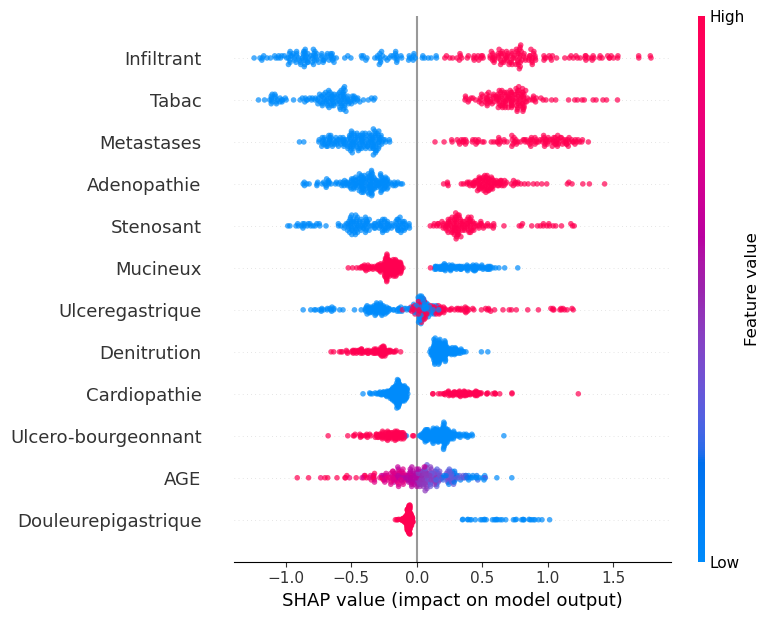

In [60]:
# Graphique SHAP
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values.values,
    X_train[selected_vars],
    plot_type="dot",
    color=plt.get_cmap("coolwarm"),
    alpha=0.7
)

Les analyses d'impact global des variables avaient permis d'identifier l'importance relative de chaque facteur dans le modèle. Ainsi, la variable **Infiltrant** avait démontré la contribution la plus élevée avec une valeur SHAP de 0.68, indiquant son rôle déterminant. La variable **Tabac** suivait avec une influence notable (SHAP = 0.54), tout comme **Metastases** (SHAP = 0.5). D'autres variables telles que **Denitrution** et **Adenopathie** avaient présenté des impacts modérés, avec des valeurs SHAP respectives de 0.35 et 0.34, tandis que **Cardiopathie** affichait une contribution légèrement inférieure (0.27). Les variables **Mucineux** et **Stenosant** avaient été moins influentes (0.23 chacune). Enfin, l’**AGE** ainsi que les symptômes gastro-intestinaux (**Douleurepigastrique**, **Ulceregastrique** et **Ulcero-bourgeonnant**) avaient montré des impacts relativement faibles, avec des valeurs SHAP respectives de 0.13, 0.1 et 0.07. Ces résultats avaient ainsi permis de hiérarchiser les facteurs prédictifs et d’éclairer la compréhension des influences de chaque variable sur le modèle.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━

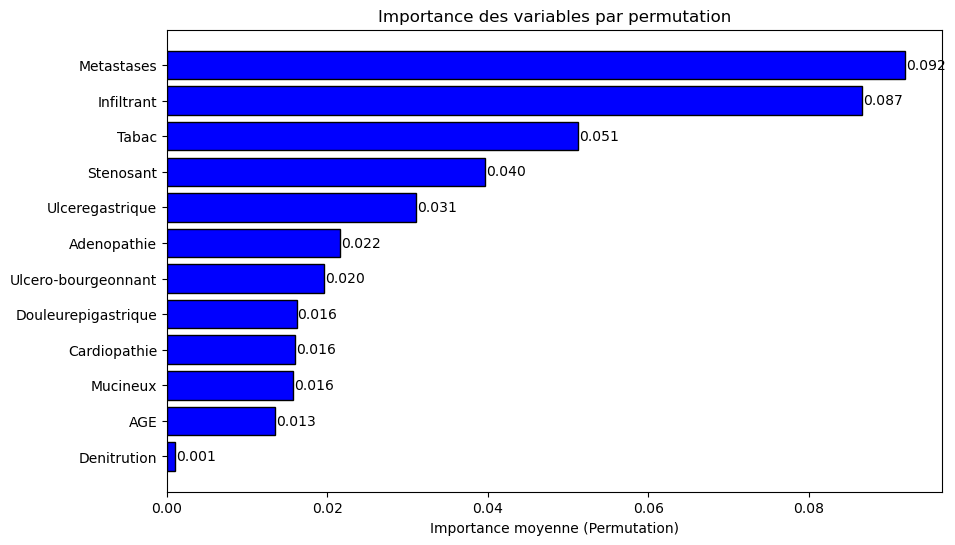

In [61]:
import tensorflow as tf
import numpy as np
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch
from sklearn.inspection import permutation_importance

# --- Définition d'une fonction de score personnalisée ---
def cindex_scorer(estimator, X, y):
    """
    Retourne le c-index calculé à partir du modèle (estimator),
    des données X et y. On s'appuie sur votre fonction evaluate_model.
    Veillez à ce que evaluate_model exécute en mode silencieux (verbose=0).
    """
    return evaluate_model(estimator, X, y)

# Application de l'importance par permutation en précisant le scoring
result = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10, random_state=42,
    scoring=cindex_scorer
)

# Organisation des résultats dans un DataFrame
importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": result.importances_mean,
    "Std Dev": result.importances_std
}).sort_values(by="Importance", ascending=False)

print(importance_df)

# Préparation des couleurs : bleu pour valeurs positives, rouge pour négatives
colors = ["blue" if val > 0 else "red" for val in importance_df["Importance"]]

# Visualisation des résultats
plt.figure(figsize=(10, 6))
bars = plt.barh(
    importance_df["Feature"],
    importance_df["Importance"],
    color=colors,
    edgecolor="black"
)
plt.gca().invert_yaxis()  # Inverser l'axe pour que la feature la plus importante apparaisse en haut
plt.xlabel("Importance moyenne (Permutation)")
plt.title("Importance des variables par permutation")

# Ajout des étiquettes sur les barres
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.0001 if width > 0 else width - 0.0001
    plt.text(
        label_x_pos, bar.get_y() + bar.get_height() / 2,
        f"{width:.3f}",
        va="center", ha="left" if width > 0 else "right",
        color="black", fontsize=10
    )

plt.show()


## **Comparaison des Models**


\begin{array}{|c|c|c|c|}
\hline
Models & C-index &  IBS  \\
\hline
\mbox{Cox PH} & 0.85 & 0.089  \\
\hline
\mbox{Random Survival Forest} & 0.85 & 0.077  \\
\hline
\mbox{Gradient Bosting Survival Tree} & 0.87 & 0.085 \\
\hline
\mbox{Deep Survival Models} & 0.89 & 0.075\\
\hline
\end{array}


La comparaison des modèles avait montré que le modèle Deep Survival Models offrait la meilleure performance, affichant un C-index de 0.89 et un Integrated Brier Score de 0.075, ce qui traduisait une discrimination et une calibration supérieures. Le modèle CoxPH et le Random Survival Forest avaient tous deux obtenu un C-index de 0.85, avec des IBS respectifs de 0.089 et 0.077, tandis que le Gradient Boosting Survival Tree avait présenté un C-index de 0.87 et un IBS de 0.085. Ces résultats avaient permis de constater que les approches basées sur les réseaux de neurones surpassaient les méthodes plus traditionnelles en termes de prédiction de la survie.

###  **Valeurs Shap**

\begin{array}{|l|c|c|c|c|c|}
\hline
Variable & Shap\_Cox & Shap\_rsf & Shap\_gbst & Shap\_DeepSurv & Valeur Moyenne \\
\hline
Metastases & 2.11 & 3.22 & 0.25 & 0.50 & 0.43 \\
\hline
Adenopathie & 1.45 & 5.2 & 0.59 & 0.34 & 0.41 \\
\hline
Infiltrant & 1.17 & 5.22 & 0.51 & 0.68 & 0.52 \\
\hline
Tabac & 1.13 & 4.97 & 0.47 & 0.54 & 0.54 \\
\hline
Mucineux & 1.12 & 0.33 & 0.04 & 0.23 & 0.65 \\
\hline
Denitrution & 0.96 & 1.28 & 0.14 & 0.35 & 0.34 \\
\hline
Ulceregastrique & 0.83 & 1.69 & 0.25 & 0.10 & 0.38 \\
\hline
Cardiopathie & 0.74 & 1.62 & 0.17 & 0.27 & 0.32 \\
\hline
Douleurepigastrique & 0.70 & 0.29 & 0.08 & 0.11 & 0.87 \\
\hline
Stenosant & 0.69 & 2.85 & 0.25 & 0.23 & 0.46 \\
\hline
AGE & 0.52 & 0.72 & 0.12 & 0.13 & 52.14 \\
\hline
Ulcerobourgeonnant & 0.51 & 1.43 & 0.09 & 0.07 & 0.34 \\
\hline
\end{array}

### **Courbes de Brier Score & IBS pour chaque modèle**

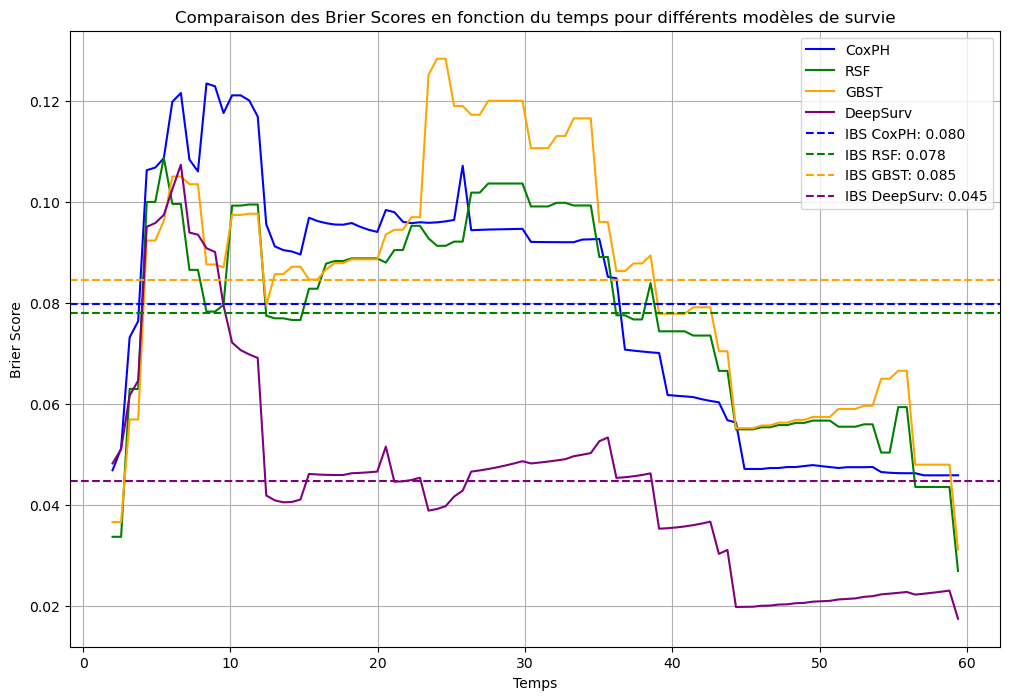

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Supposons que time_grid est la grille de temps utilisée pour l'évaluation
# et que brier_scores_cox, brier_scores_rsf, brier_scores_gbst, brier_scores_deepsurv
# sont les Brier Scores calculés pour chaque modèle à chaque instant de time_grid.

plt.figure(figsize=(12, 8))

# Courbes de Brier Score pour chaque modèle
plt.plot(time_grid, brier_scores_test_cox, label='CoxPH', color='blue')
plt.plot(time_grid, brier_scores_test_rsf, label='RSF', color='green')
plt.plot(time_grid, brier_scores_test_gbst, label='GBST', color='orange')
plt.plot(time_grid, brier_scores_test_deepsurv, label='DeepSurv', color='purple')

# Lignes horizontales pour les IBS
plt.axhline(y=ibs_test_cox, color='blue', linestyle='--', label=f'IBS CoxPH: {ibs_test_cox:.3f}')
plt.axhline(y=ibs_test_rsf, color='green', linestyle='--', label=f'IBS RSF: {ibs_test_rsf:.3f}')
plt.axhline(y=ibs_test_gbst, color='orange', linestyle='--', label=f'IBS GBST: {ibs_test_gbst:.3f}')
plt.axhline(y=ibs_test_deepsurv, color='purple', linestyle='--', label=f'IBS DeepSurv: {ibs_test_deepsurv:.3f}')

plt.xlabel('Temps')
plt.ylabel('Brier Score')
plt.title('Comparaison des Brier Scores en fonction du temps pour différents modèles de survie')
plt.legend()
plt.grid(True)
plt.show()

Les graphiques de l'Integrated Brier Score avaient montré une tendance claire : le modèle Deep Survival Models avait présenté les courbes les plus basses, traduisant ainsi une meilleure calibration et une prédiction plus précise au fil du temps. En comparaison, les autres modèles affichaient des valeurs légèrement supérieures, ce qui indiquait une performance prédictive moins optimale. Ces visualisations avaient confirmé les résultats globaux obtenus lors de l'évaluation des modèles.

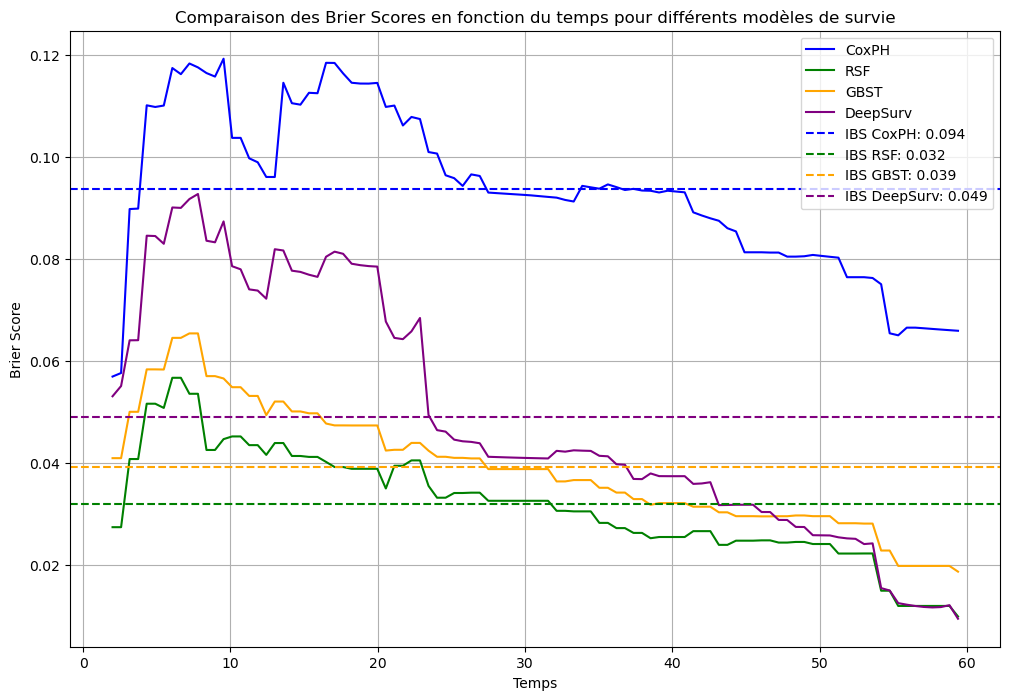

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Supposons que time_grid est la grille de temps utilisée pour l'évaluation
# et que brier_scores_cox, brier_scores_rsf, brier_scores_gbst, brier_scores_deepsurv
# sont les Brier Scores calculés pour chaque modèle à chaque instant de time_grid.

plt.figure(figsize=(12, 8))

# Courbes de Brier Score pour chaque modèle
plt.plot(time_grid, brier_scores_train_cox, label='CoxPH', color='blue')
plt.plot(time_grid, brier_scores_train_rsf, label='RSF', color='green')
plt.plot(time_grid, brier_scores_train_gbst, label='GBST', color='orange')
plt.plot(time_grid, brier_scores_train_deepsurv, label='DeepSurv', color='purple')

# Lignes horizontales pour les IBS
plt.axhline(y=ibs_train_cox, color='blue', linestyle='--', label=f'IBS CoxPH: {ibs_train_cox:.3f}')
plt.axhline(y=ibs_train_rsf, color='green', linestyle='--', label=f'IBS RSF: {ibs_train_rsf:.3f}')
plt.axhline(y=ibs_train_gbst, color='orange', linestyle='--', label=f'IBS GBST: {ibs_train_gbst:.3f}')
plt.axhline(y=ibs_train_deepsurv, color='purple', linestyle='--', label=f'IBS DeepSurv: {ibs_train_deepsurv:.3f}')

plt.xlabel('Temps')
plt.ylabel('Brier Score')
plt.title('Comparaison des Brier Scores en fonction du temps pour différents modèles de survie')
plt.legend()
plt.grid(True)
plt.show()

# **Deploiement des Modèles**
## **Sauvegarde du modèle**

In [59]:
import joblib
#Pour Cox Proportional Hazards
joblib.dump(cph, "coxph.pkl")
#Pour Random Survival Forest
joblib.dump(rsf, "rsf.pkl")
#Pour Gradient Boosting Survival Tree
joblib.dump(gbst, "gbst.pkl")
# Sauvegarde en format .keras
best_model.save("deepsurv.keras")

In [ ]:
import streamlit as st